In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, broom, zoo)
theme_set(lal_plot_theme_d())

options(repr.plot.width = 15, repr.plot.height = 12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "broom"      TRUE  
[7,] "zoo"        TRUE  


# Covidtracking Project data viz
https://covidtracking.com/api

In [2]:
system("rm -f daily.csv")
system("wget https://covidtracking.com/api/v1/states/daily.csv")

In [3]:
state_tests = fread('daily.csv')
state_tests[, d := anydate(date)]
state_tests[, day := weekdays(d)]
dropcols = c('hash', 'dateChecked')
state_tests[, (dropcols) := NULL]
state_tests %>% glimpse()

Rows: 3,433
Columns: 27
$ date                     <int> 20200505, 20200505, 20200505, 20200505, 2020…
$ state                    <chr> "AK", "AL", "AR", "AS", "AZ", "CA", "CO", "C…
$ positive                 <int> 371, 8285, 3496, 0, 9305, 56212, 16907, 3062…
$ negative                 <int> 22321, 98481, 51139, 83, 78955, 723690, 6809…
$ pending                  <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 1265…
$ hospitalizedCurrently    <int> 13, NA, 89, NA, 728, 4622, 834, 1500, 447, 2…
$ hospitalizedCumulative   <int> NA, 1107, 453, NA, 1397, NA, 2838, 7758, NA,…
$ inIcuCurrently           <int> NA, NA, NA, NA, 303, 1388, NA, NA, 130, NA, …
$ inIcuCumulative          <int> NA, 428, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ onVentilatorCurrently    <int> NA, NA, 16, NA, 185, NA, NA, NA, 91, NA, NA,…
$ onVentilatorCumulative   <int> NA, 255, 89, NA, NA, NA, NA, NA, NA, NA, NA,…
$ recovered                <int> 277, NA, 2041, NA, 1671, NA, 2743, 4346, 667…
$ dataQualityGrade         <

In [4]:
state_tests[, tpr := positive / totalTestResults]
state_tests[, cfr := death / positive ]
state_tests[, tpr_new := positiveIncrease / totalTestResultsIncrease]
(most_affected = 
     state_tests[d == max(state_tests$d)][
    order(-positive)][
    1:10, c("state", "d", "positive", "death", "positiveIncrease", "deathIncrease")]
 )

state,d,positive,death,positiveIncrease,deathIncrease
<chr>,<date>,<int>,<int>,<int>,<int>
NY,2020-05-05,321192,19645,2239,230
NJ,2020-05-05,130593,8244,2324,334
MA,2020-05-05,70271,4212,1184,122
IL,2020-05-05,65962,2838,2122,176
CA,2020-05-05,56212,2317,1275,63
PA,2020-05-05,50957,3012,865,554
MI,2020-05-05,44397,4179,643,130
FL,2020-05-05,37439,1536,542,113
TX,2020-05-05,33369,906,1037,22


In [5]:
t10states = state_tests[positive >= 10 & state %in% most_affected$state]

In [6]:
setorder(t10states, state, date)

smoothvars = c("positive", "hospitalizedCurrently", "cfr", "death", "totalTestResults", 
              "positiveIncrease", "hospitalizedIncrease", "deathIncrease", "totalTestResultsIncrease",
              'tpr', 'tpr_new')

t10states[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), 
   by = .(state), .SDcols = smoothvars]

# t10states[, tpr_rm3 := rollmeanr(tpr, 3, fill = NA), by = .(state)]

# Plots 

## Natl Time Series

In [7]:
nat_ts = state_tests[, lapply(.SD, sum, na.rm = T), by = d, 
                     .SDcols = c("positive", "positiveIncrease", "totalTestResults", "totalTestResultsIncrease", "death", "deathIncrease")][, 
    `:=`(cfr = death/positive,
         tpr = positive/totalTestResults,
         tpr_n = positiveIncrease/totalTestResultsIncrease
         )]

smoothvars = c("positive", "positiveIncrease", "death", "deathIncrease", "tpr_n", "cfr", "tpr", "totalTestResultsIncrease")

nat_ts[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), .SDcols = smoothvars]
nat_ts[, .(positive, positiveIncrease, death, deathIncrease, totalTestResults, totalTestResultsIncrease)] %>% head

positive,positiveIncrease,death,deathIncrease,totalTestResults,totalTestResultsIncrease
<int>,<int>,<int>,<int>,<int>,<int>
1195605,22348,65307,2527,7544328,259150
1173257,21251,62780,912,7285178,231812
1152006,26287,61868,1158,7053366,248125
1125719,30038,60710,1651,6805241,253431
1095681,33178,59059,1739,6551810,296041
1062503,29346,57320,2095,6255769,229599


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



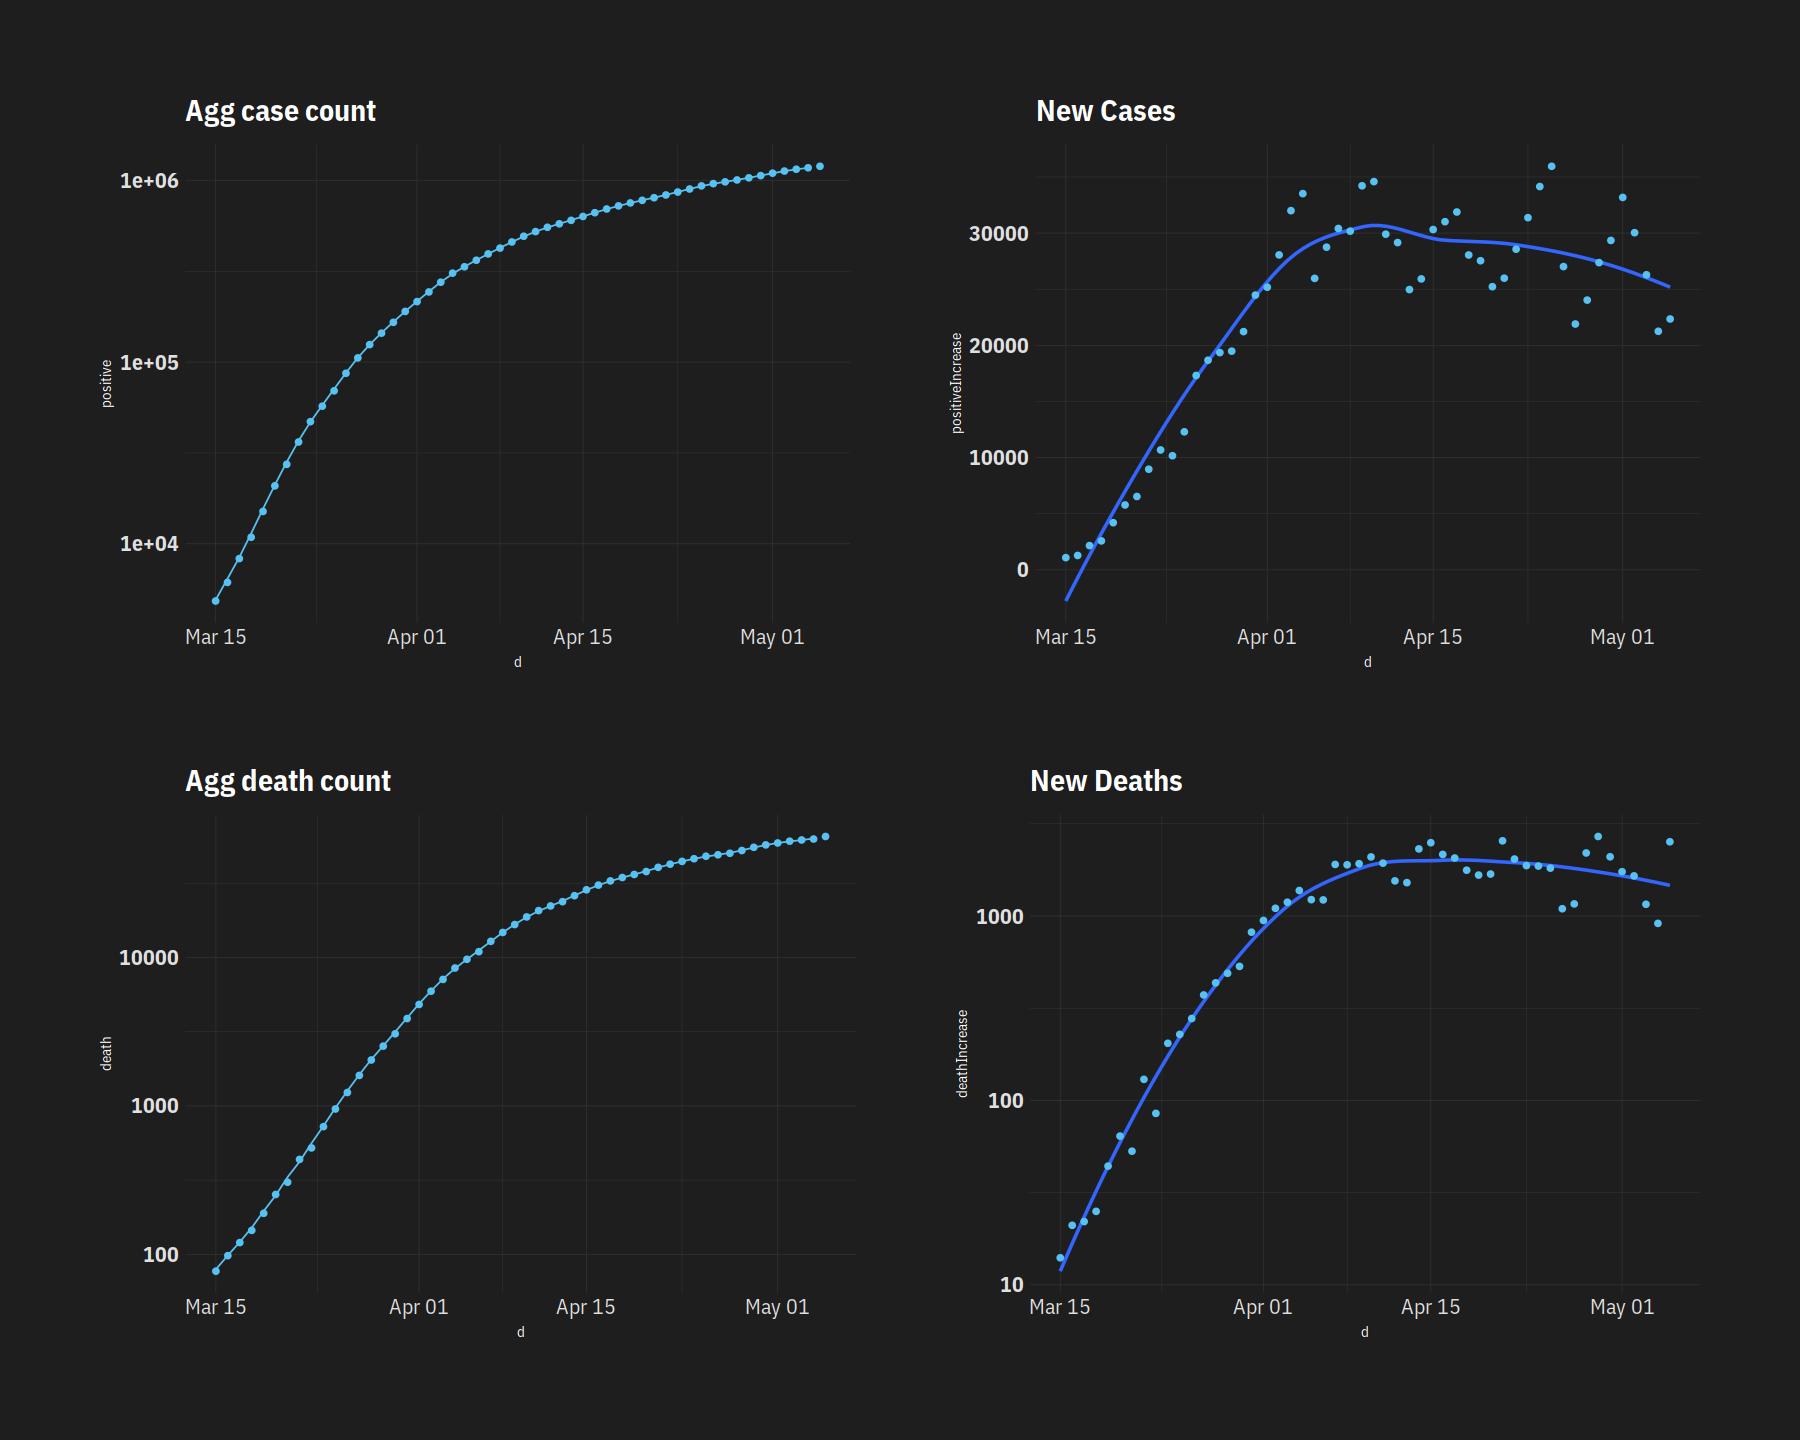

In [9]:
p1 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = positive)) + scale_y_log10() +
    geom_point() + geom_line(aes(y = rm3_positive)) + ggtitle("Agg case count")

p2 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = positiveIncrease)) + geom_smooth(se = F) + 
    geom_point() + ggtitle("New Cases")

p3 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = death)) + scale_y_log10() + geom_line(aes(y = rm3_death)) +
    geom_point() + ggtitle("Agg death count")

p4 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = deathIncrease)) + scale_y_log10() + geom_smooth(se = F) +
    geom_point() + ggtitle("New Deaths")

(p1 | p2)/(p3 | p4)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



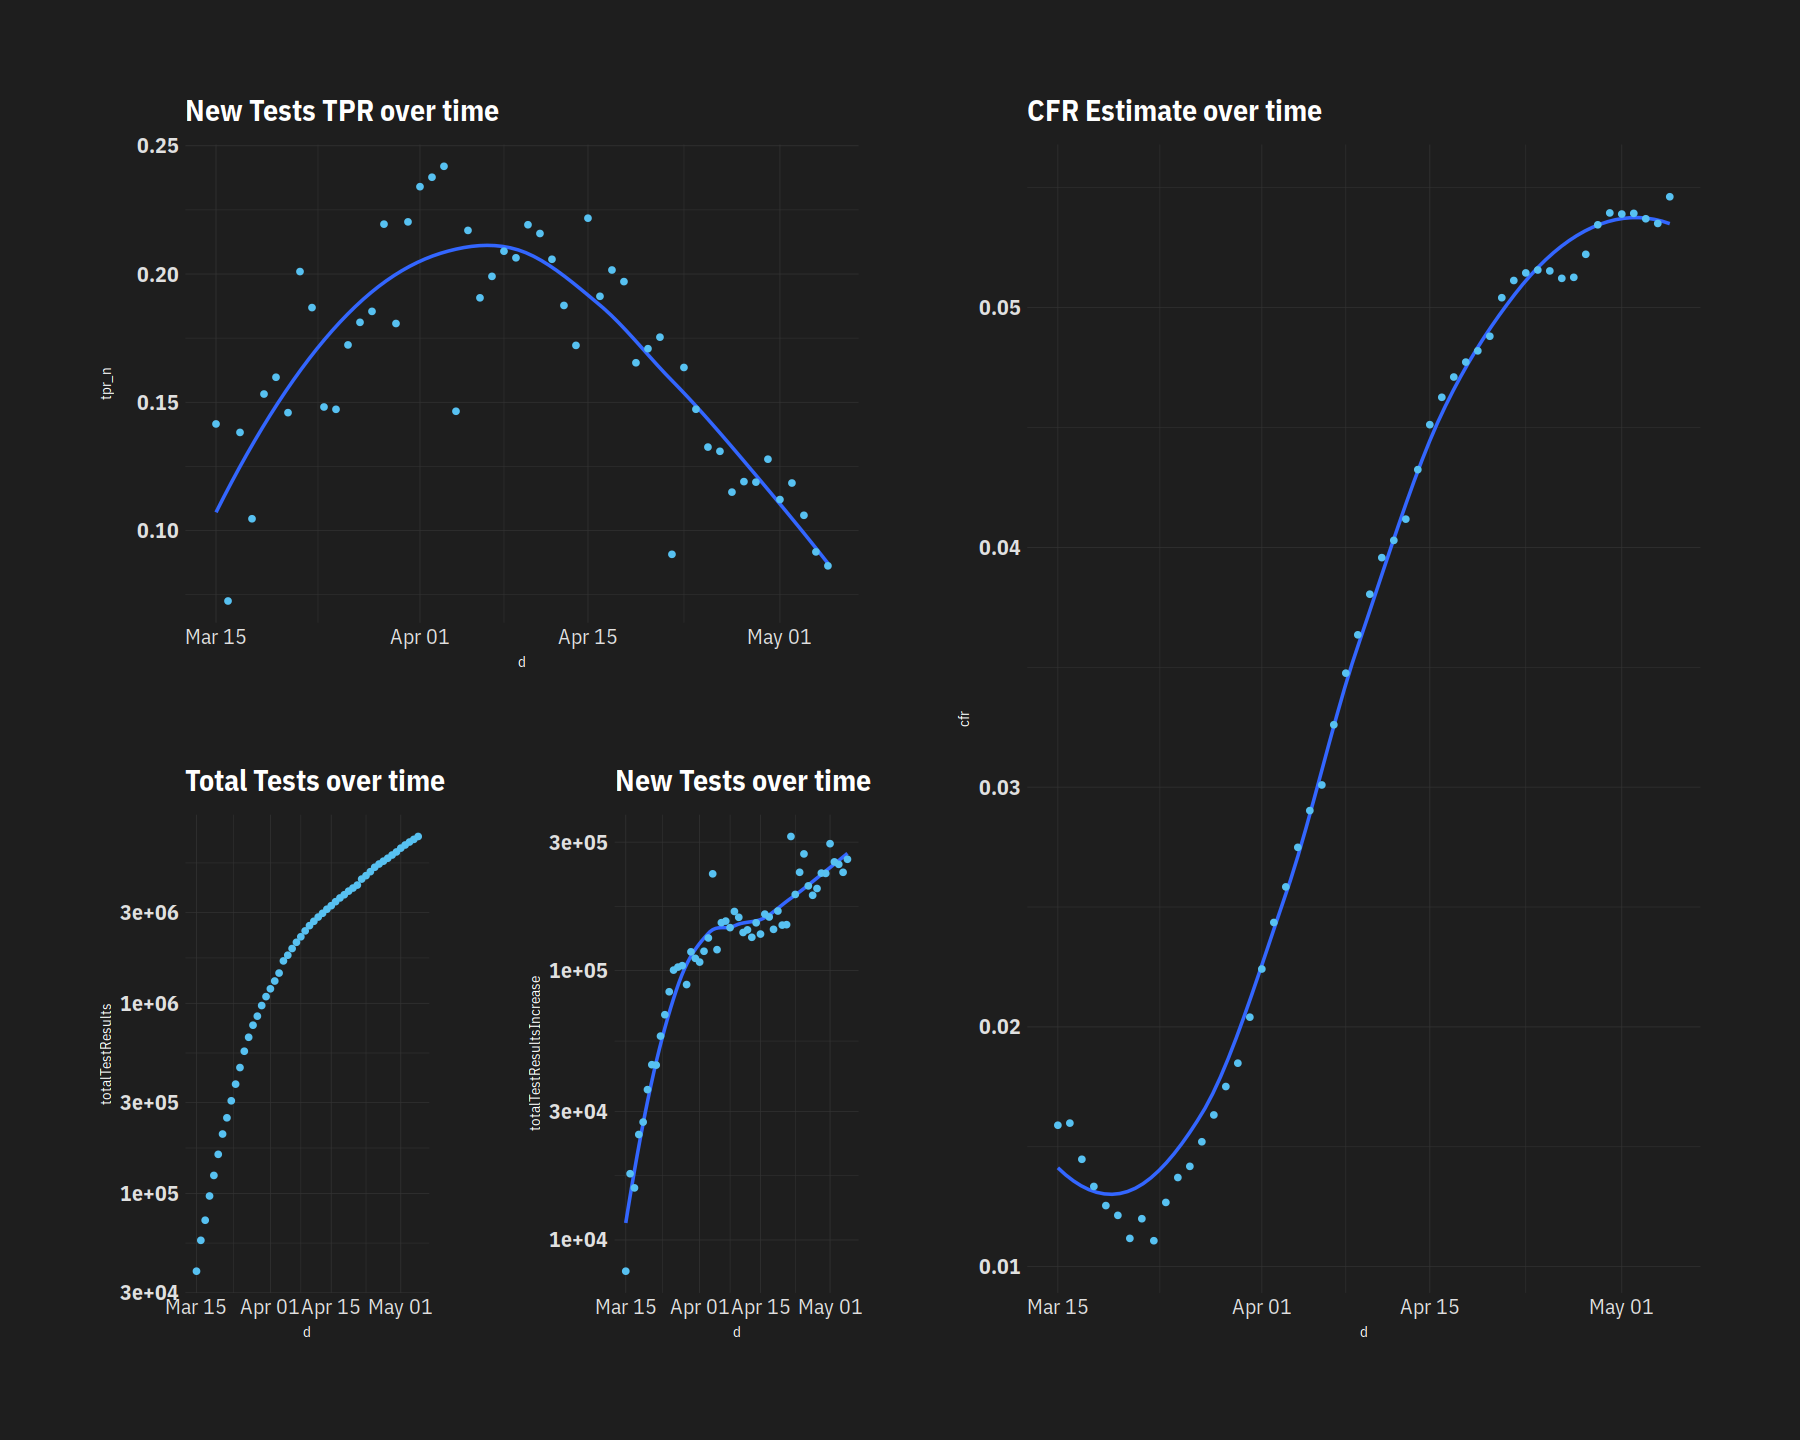

In [10]:
p1 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = tpr)) +
    geom_point() + geom_smooth(se = F) + ggtitle("TPR over time")

p2 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = tpr_n)) + geom_smooth(se = F) +
    geom_point() + ggtitle("New Tests TPR over time")
p3 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = totalTestResults)) + scale_y_log10() +
    geom_point() + ggtitle("Total Tests over time")

p4 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = totalTestResultsIncrease)) + 
    scale_y_log10() + geom_smooth(se = F) +
    geom_point() + ggtitle("New Tests over time")

p5 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = cfr)) + geom_smooth(se = F) +
    geom_point() + ggtitle("CFR Estimate over time")
(p2)/(p3 | p4) | p5

In [11]:
# generic function to plot time series
plot_ts = function(df, col, t = "Time Series of", logtransform = F, rm = T){
    p = ggplot(df, aes_string(x = 'd', y = col, colour = 'state', group = 'state')) +
        geom_point( size = 0.7) + 
        # plot rolling mean line
        scale_colour_brewer(palette = "Spectral") +
        labs(
            title = t,
            subtitle = paste(unique(df$state), collapse = ", ")
        )
    if (rm == T) {
        p = p + geom_line(aes_string(y = paste0("rm3_", col))) 
    } else{
        p = p + geom_smooth(se = F)
    }
    if (logtransform == T) p = p + scale_y_log10()
    return(p)
}

## Cases 

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 15 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


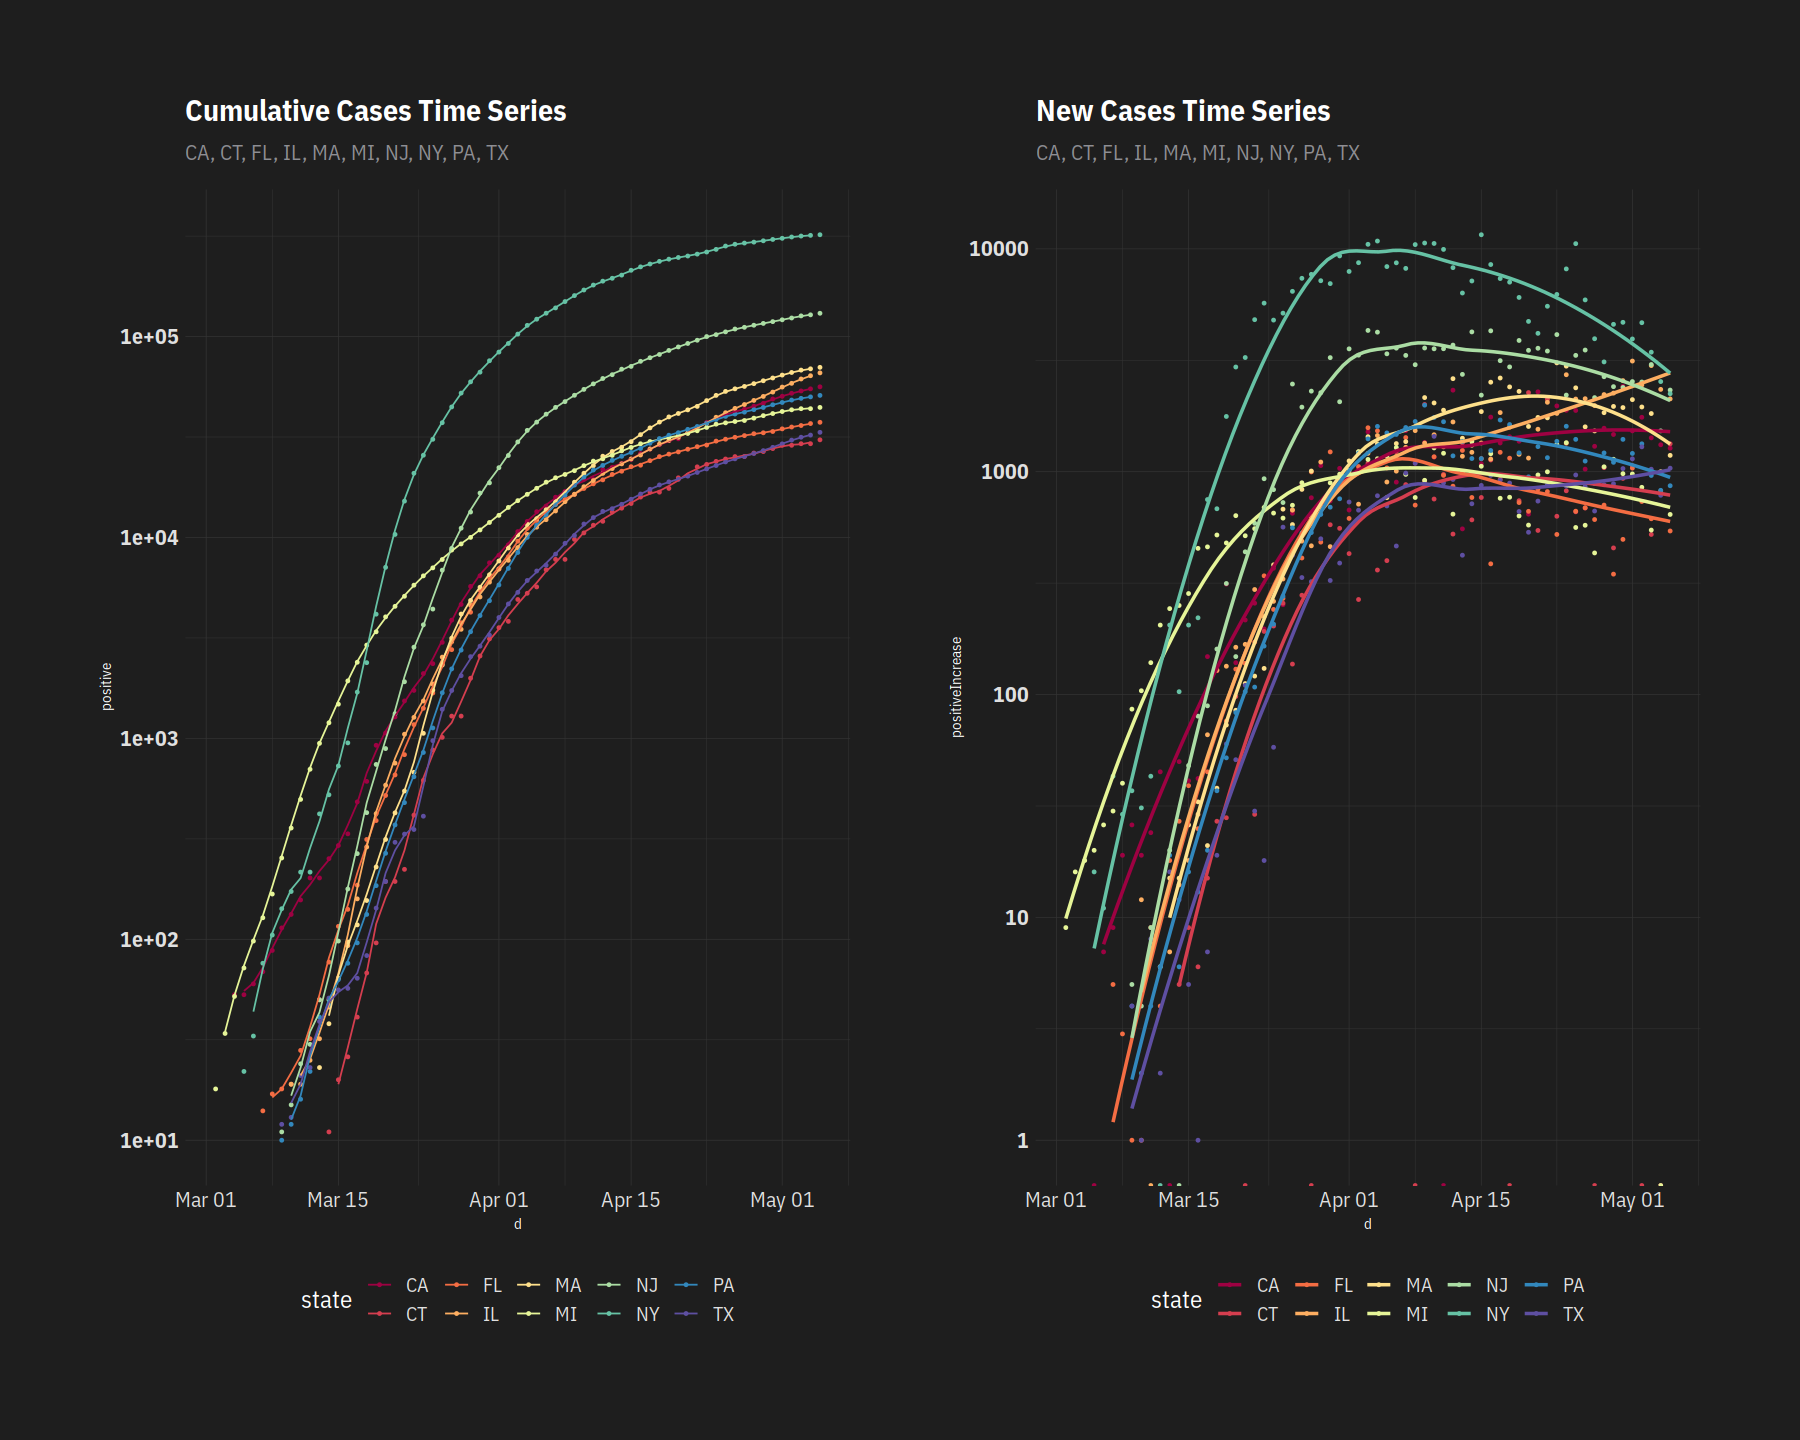

In [18]:
p1 = plot_ts(t10states, 'positive', "Cumulative Cases Time Series", T)
p2 = plot_ts(t10states, 'positiveIncrease', "New Cases Time Series", T, F)
(p1 | p2)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 15 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


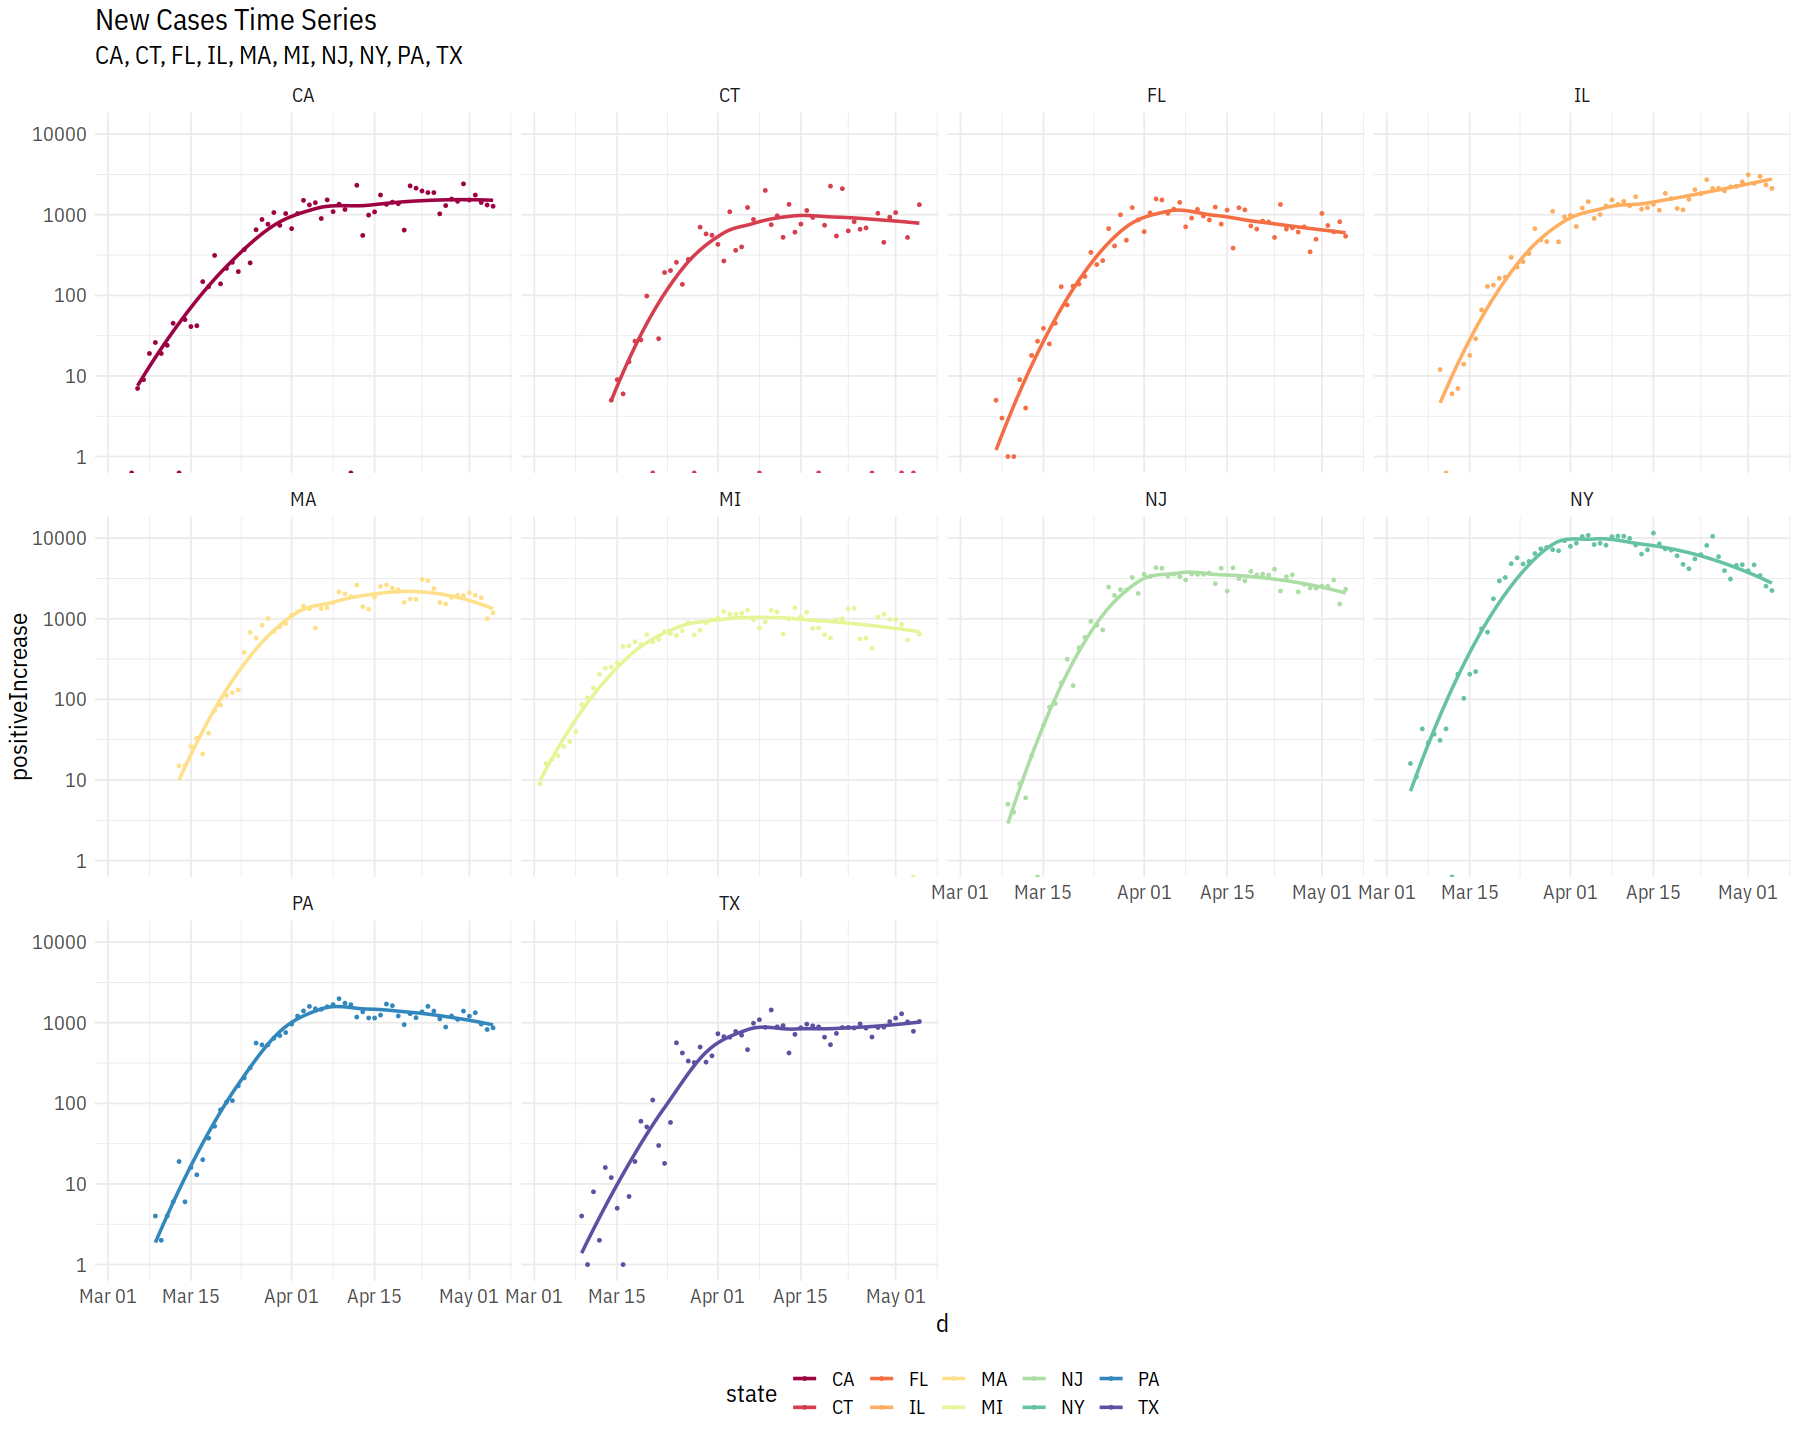

In [19]:
p2 + facet_wrap(~ state) + lal_plot_theme()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 75 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 75 rows containing missing values (geom_point).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 104 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


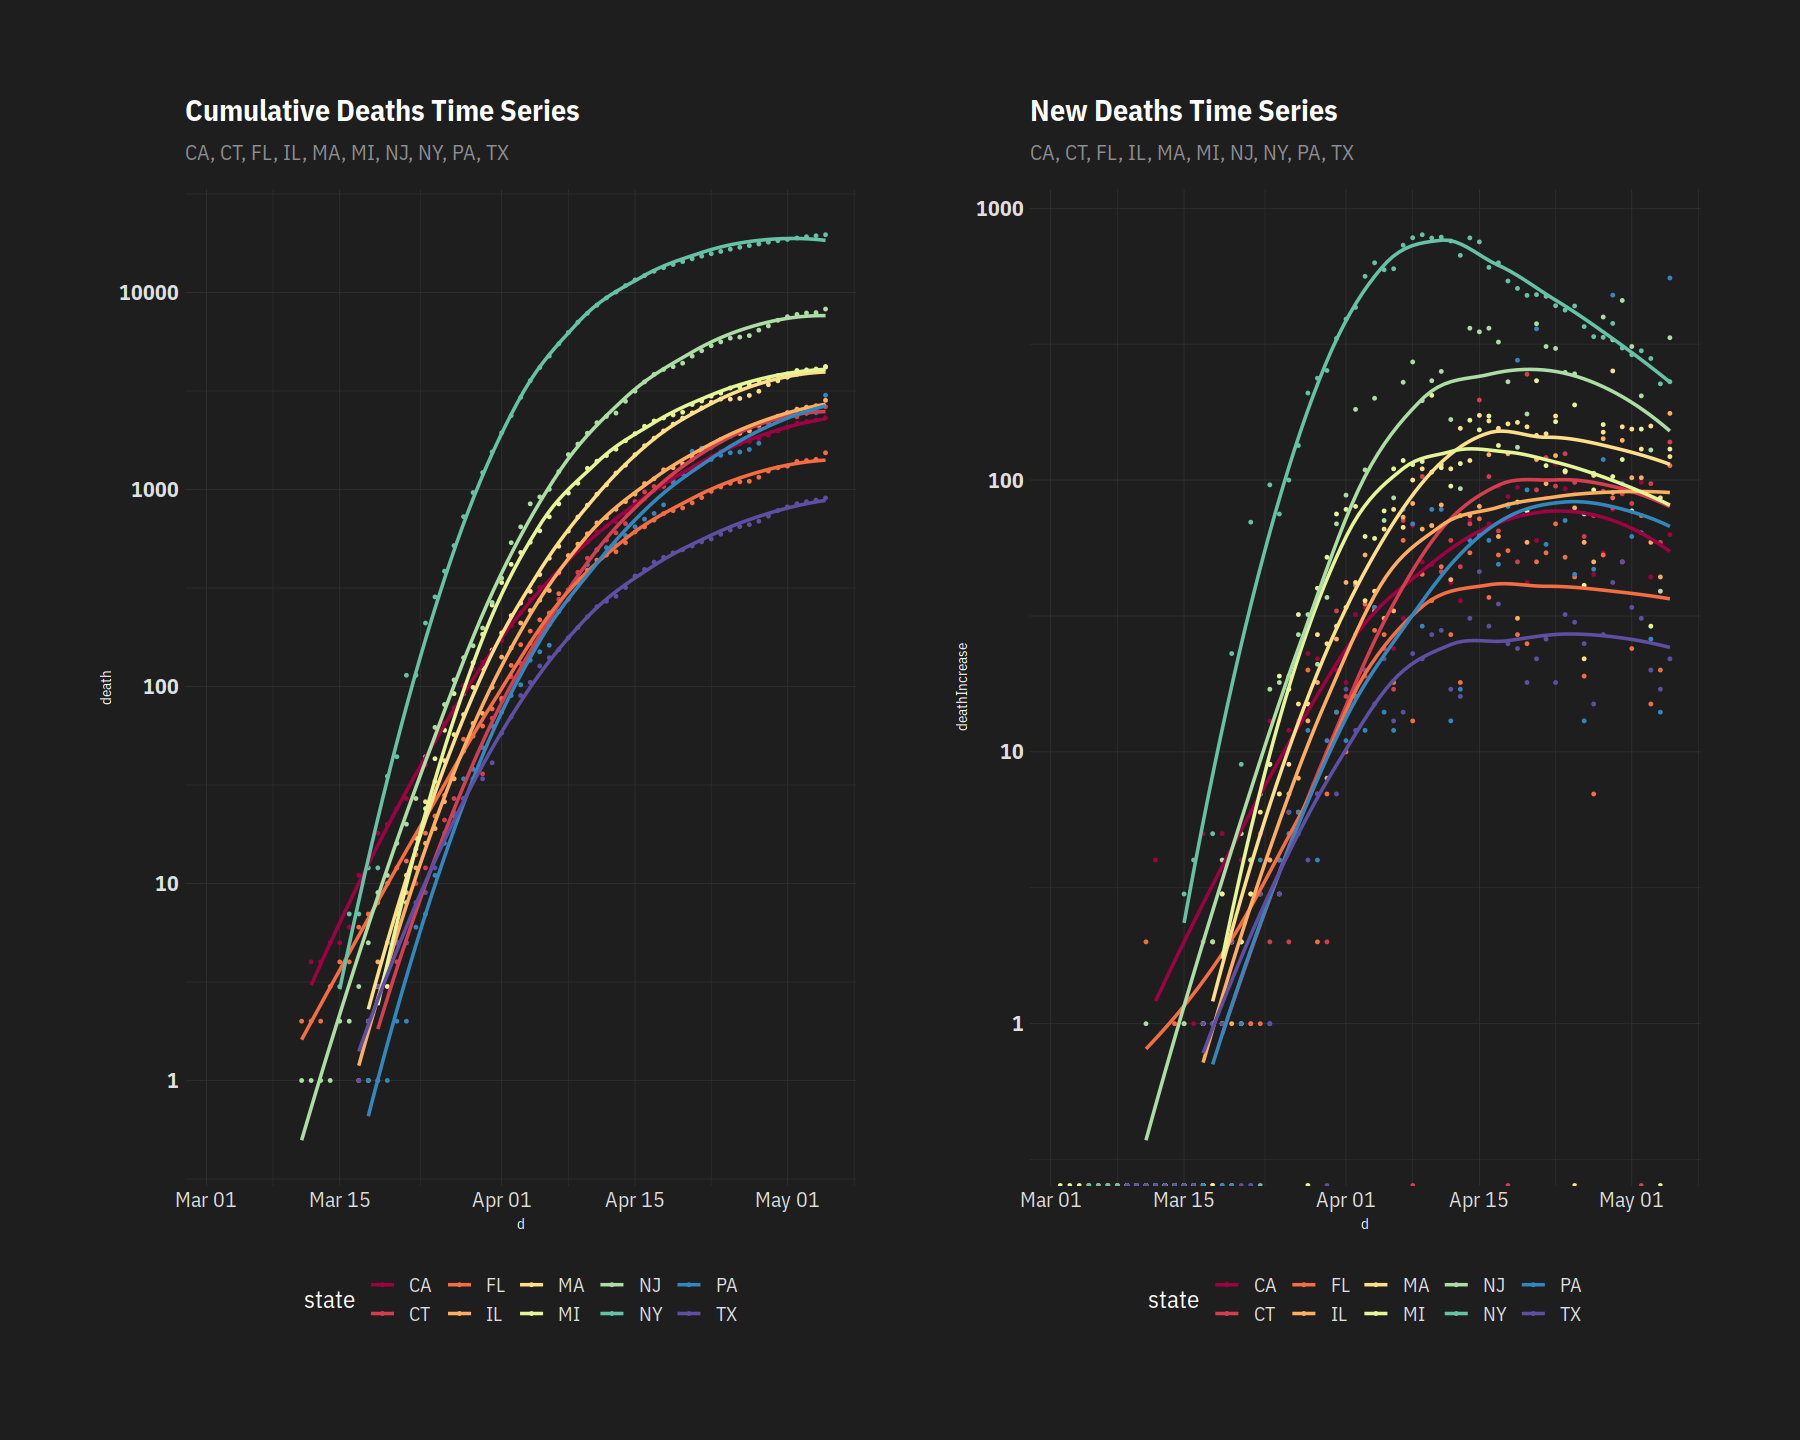

In [20]:
p1 = plot_ts(t10states, 'death', "Cumulative Deaths Time Series", T, F)
p2 = plot_ts(t10states, 'deathIncrease', "New Deaths Time Series", T, F)
(p1 | p2)

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 104 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


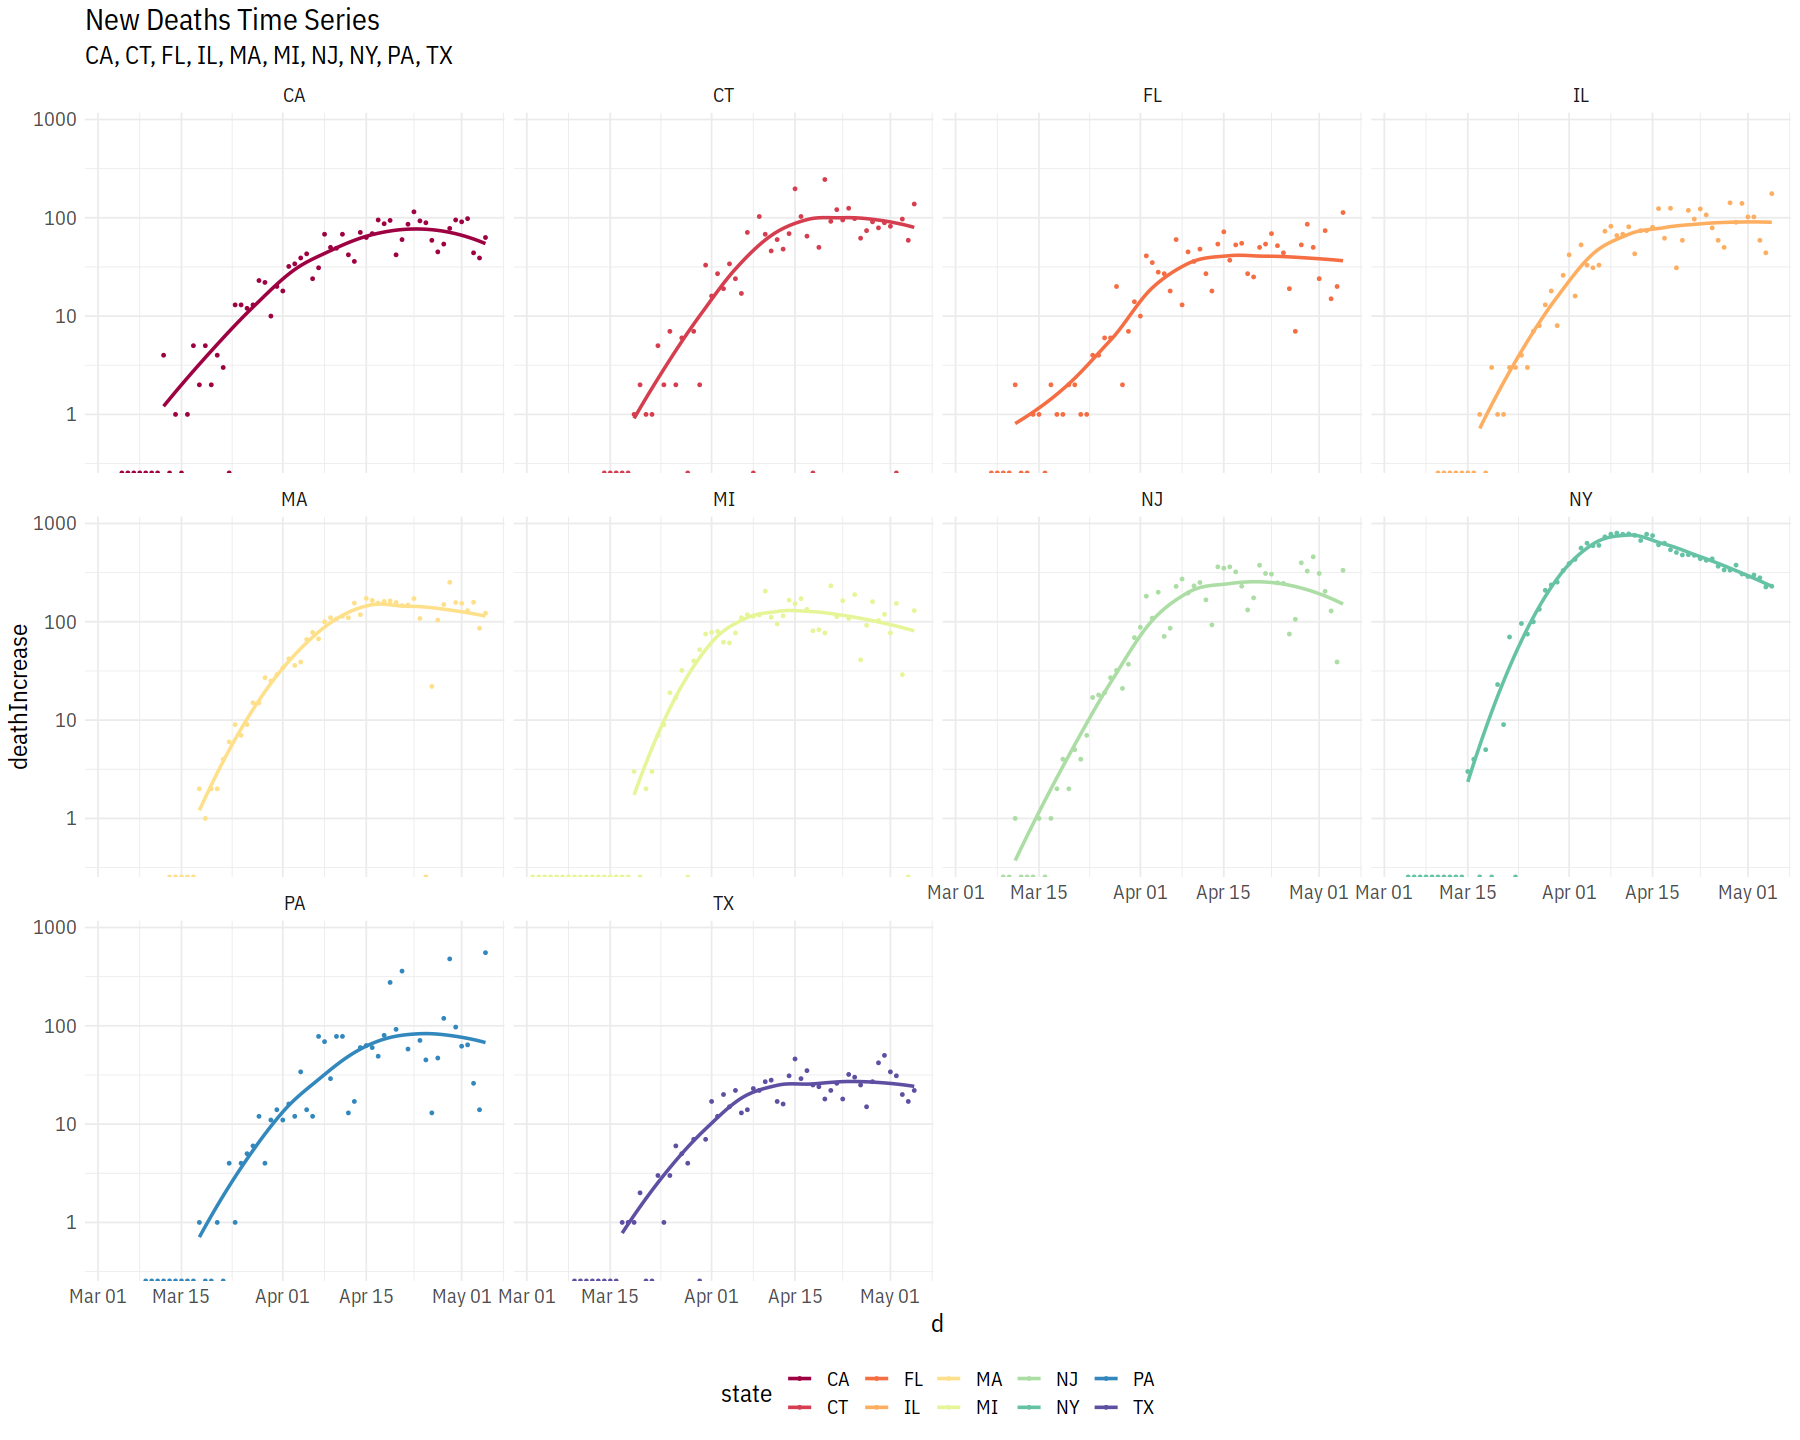

In [21]:
p2 + facet_wrap(~ state) + lal_plot_theme()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 18 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”


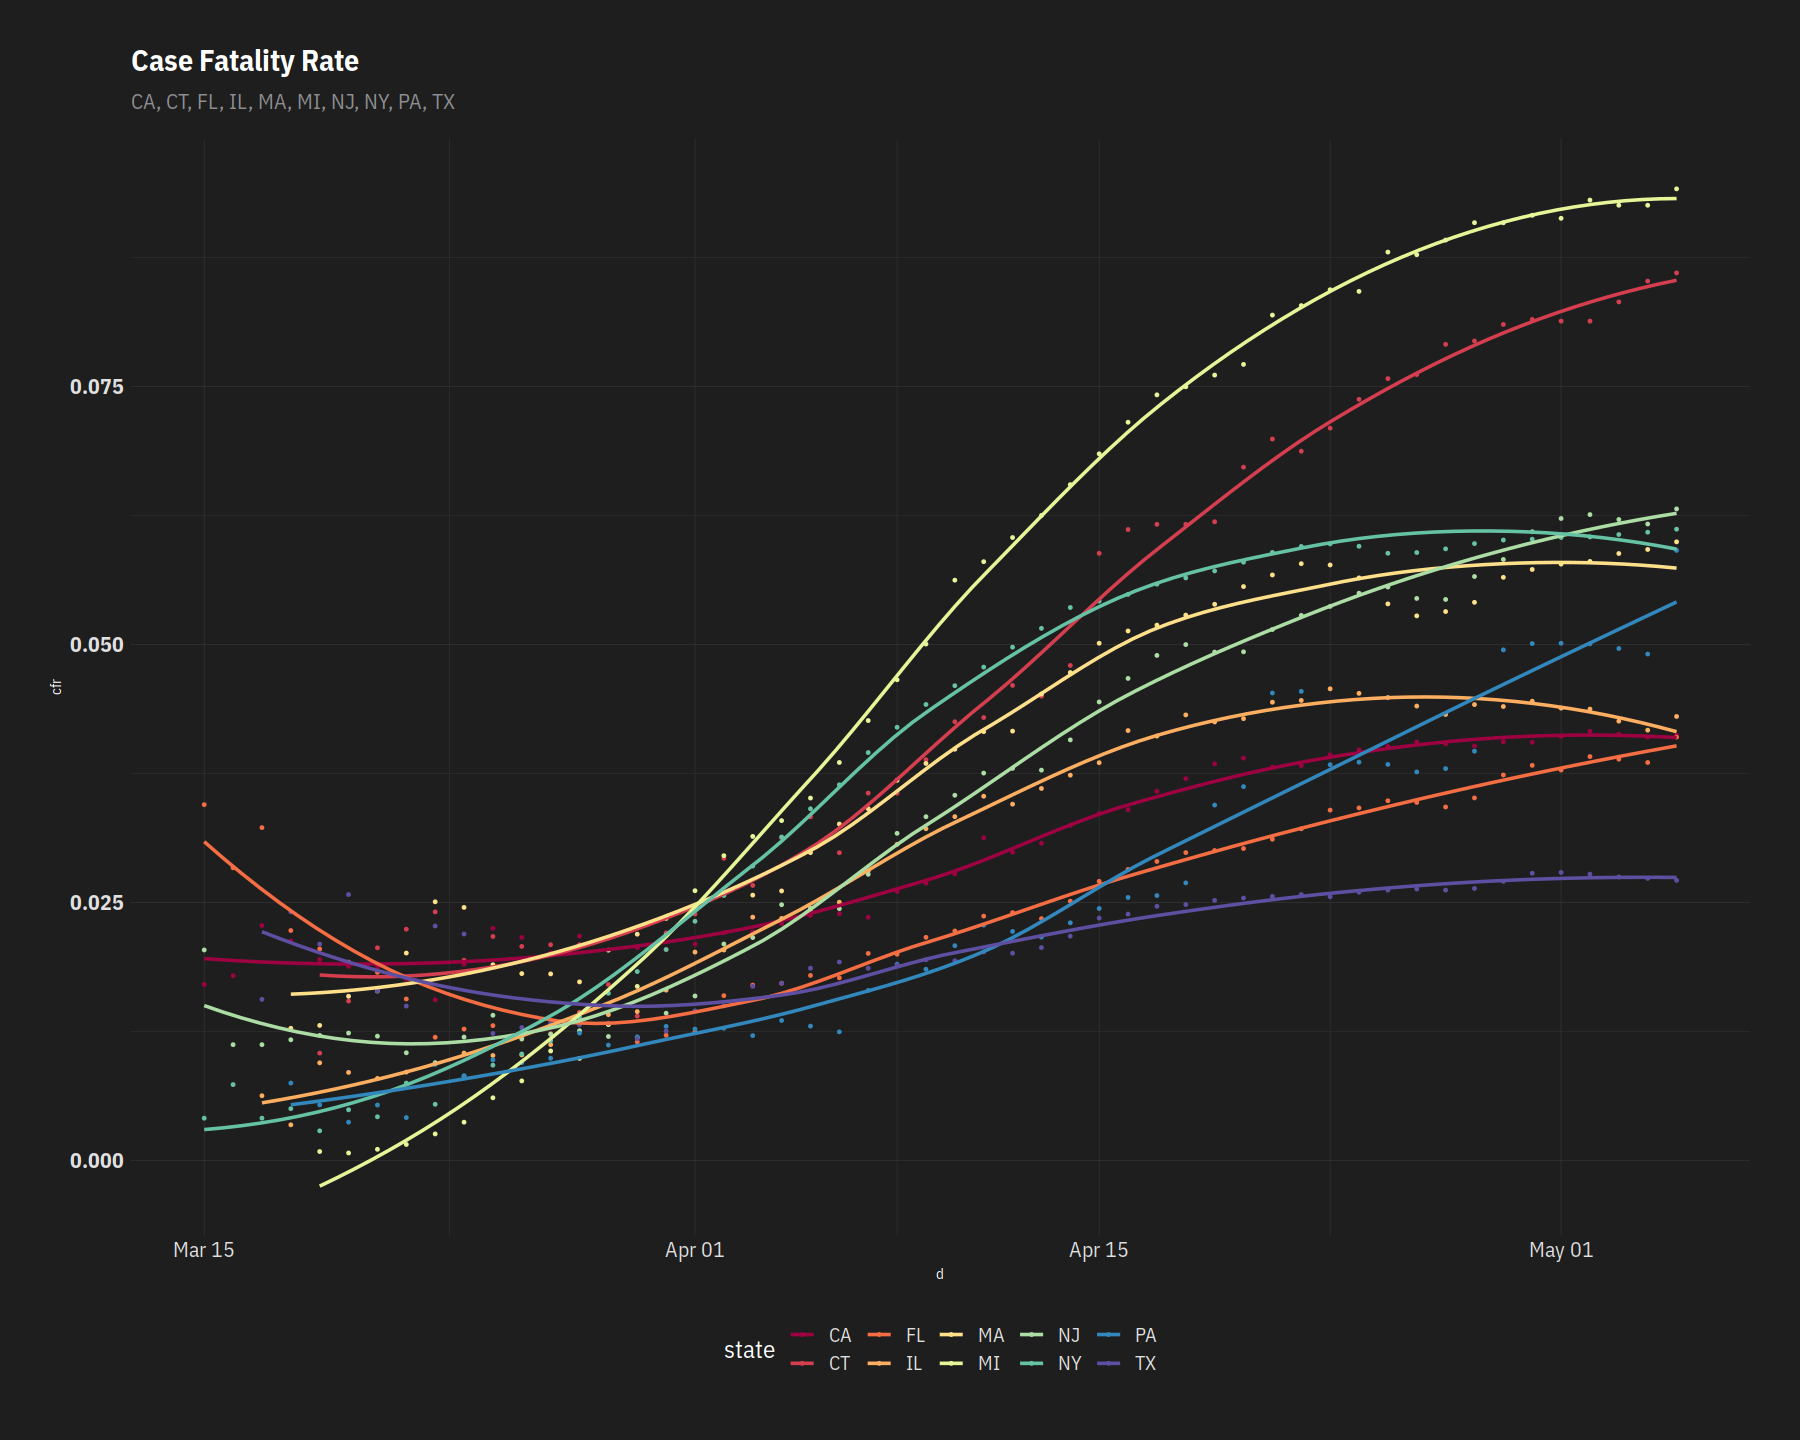

In [14]:
(cfp = plot_ts(t10states[d >= "2020-03-15"], "cfr", "Case Fatality Rate", F, F))

## Tests 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


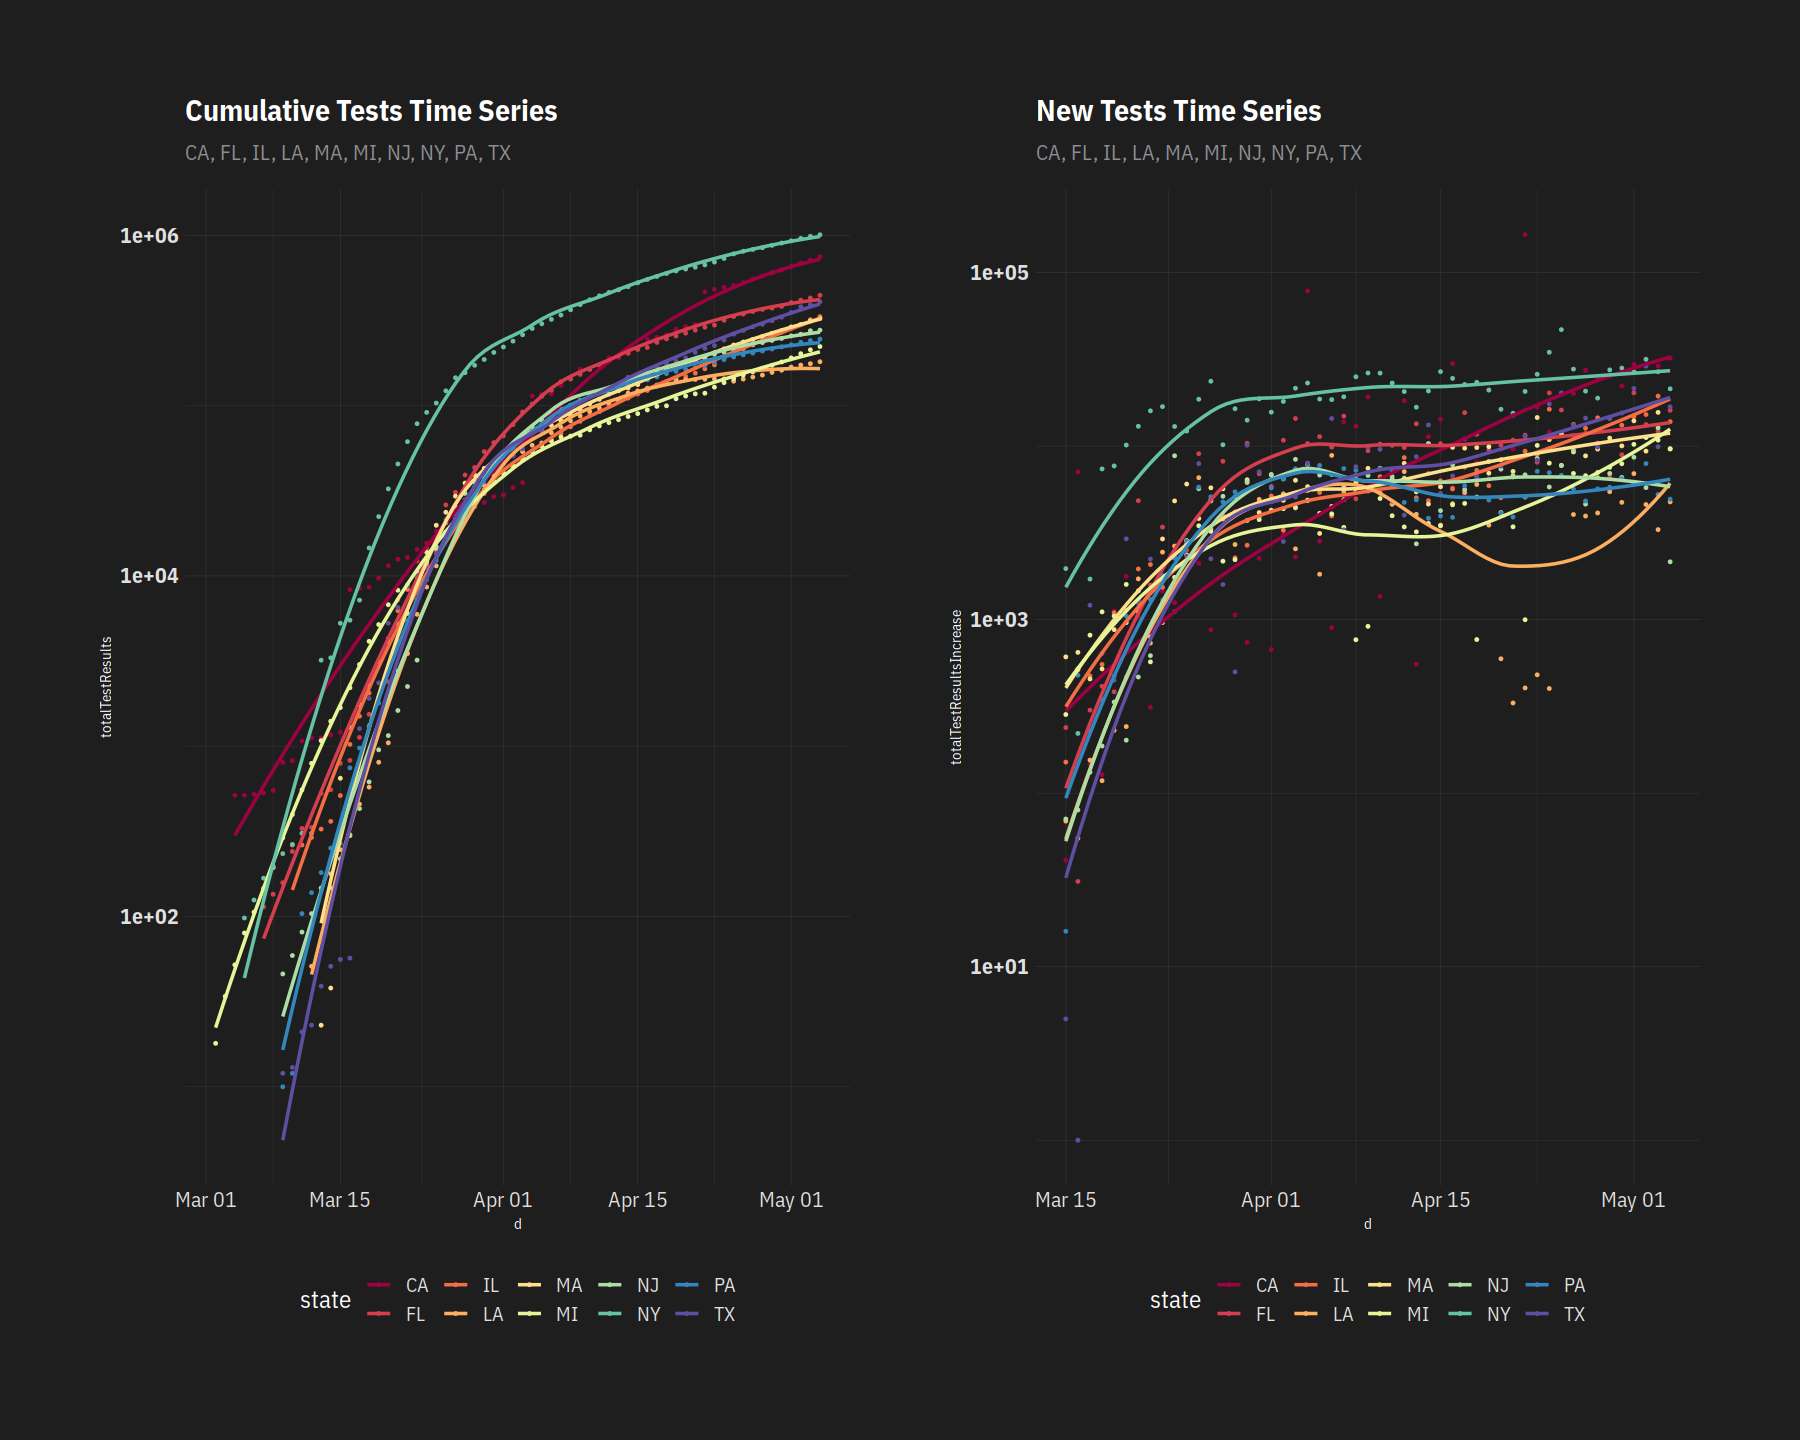

In [16]:
p = plot_ts(t10states, 'totalTestResults', "Cumulative Tests Time Series", T, F)
p2 = plot_ts(t10states[d >= '2020-03-15'], 'totalTestResultsIncrease', "New Tests Time Series", T, F)

(p | p2)

# Shares over time  

In [17]:
t10states[, rm3_deathIncrease := ifelse(rm3_deathIncrease < 0, 0, deathIncrease)]
t10states[, rm3_totalTestResultsIncrease := ifelse(rm3_totalTestResultsIncrease < 0, 0, rm3_totalTestResultsIncrease)]

t10states[, denom_cases := sum(rm3_positiveIncrease), by = d][, 
            denom_deaths := sum(rm3_deathIncrease), by = d]
t10states[, newcase_share := rm3_positiveIncrease / denom_cases][, 
            newdeath_share := rm3_deathIncrease/denom_deaths]

t10states[, rm3_totalTestResultsIncrease := ifelse(rm3_totalTestResultsIncrease < 0, 0, rm3_totalTestResultsIncrease)]
t10states[, denom_tests := sum(rm3_totalTestResultsIncrease), by = d]
t10states[, tests_share := rm3_totalTestResultsIncrease / denom_tests]

In [18]:
t10states[, stgroup := case_when(
    state %in% c("NY", "NJ", "MA", "CT", "PA") ~ paste0("1_", state), # group northeast
    TRUE ~ paste0("2_", state)
)]

Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”


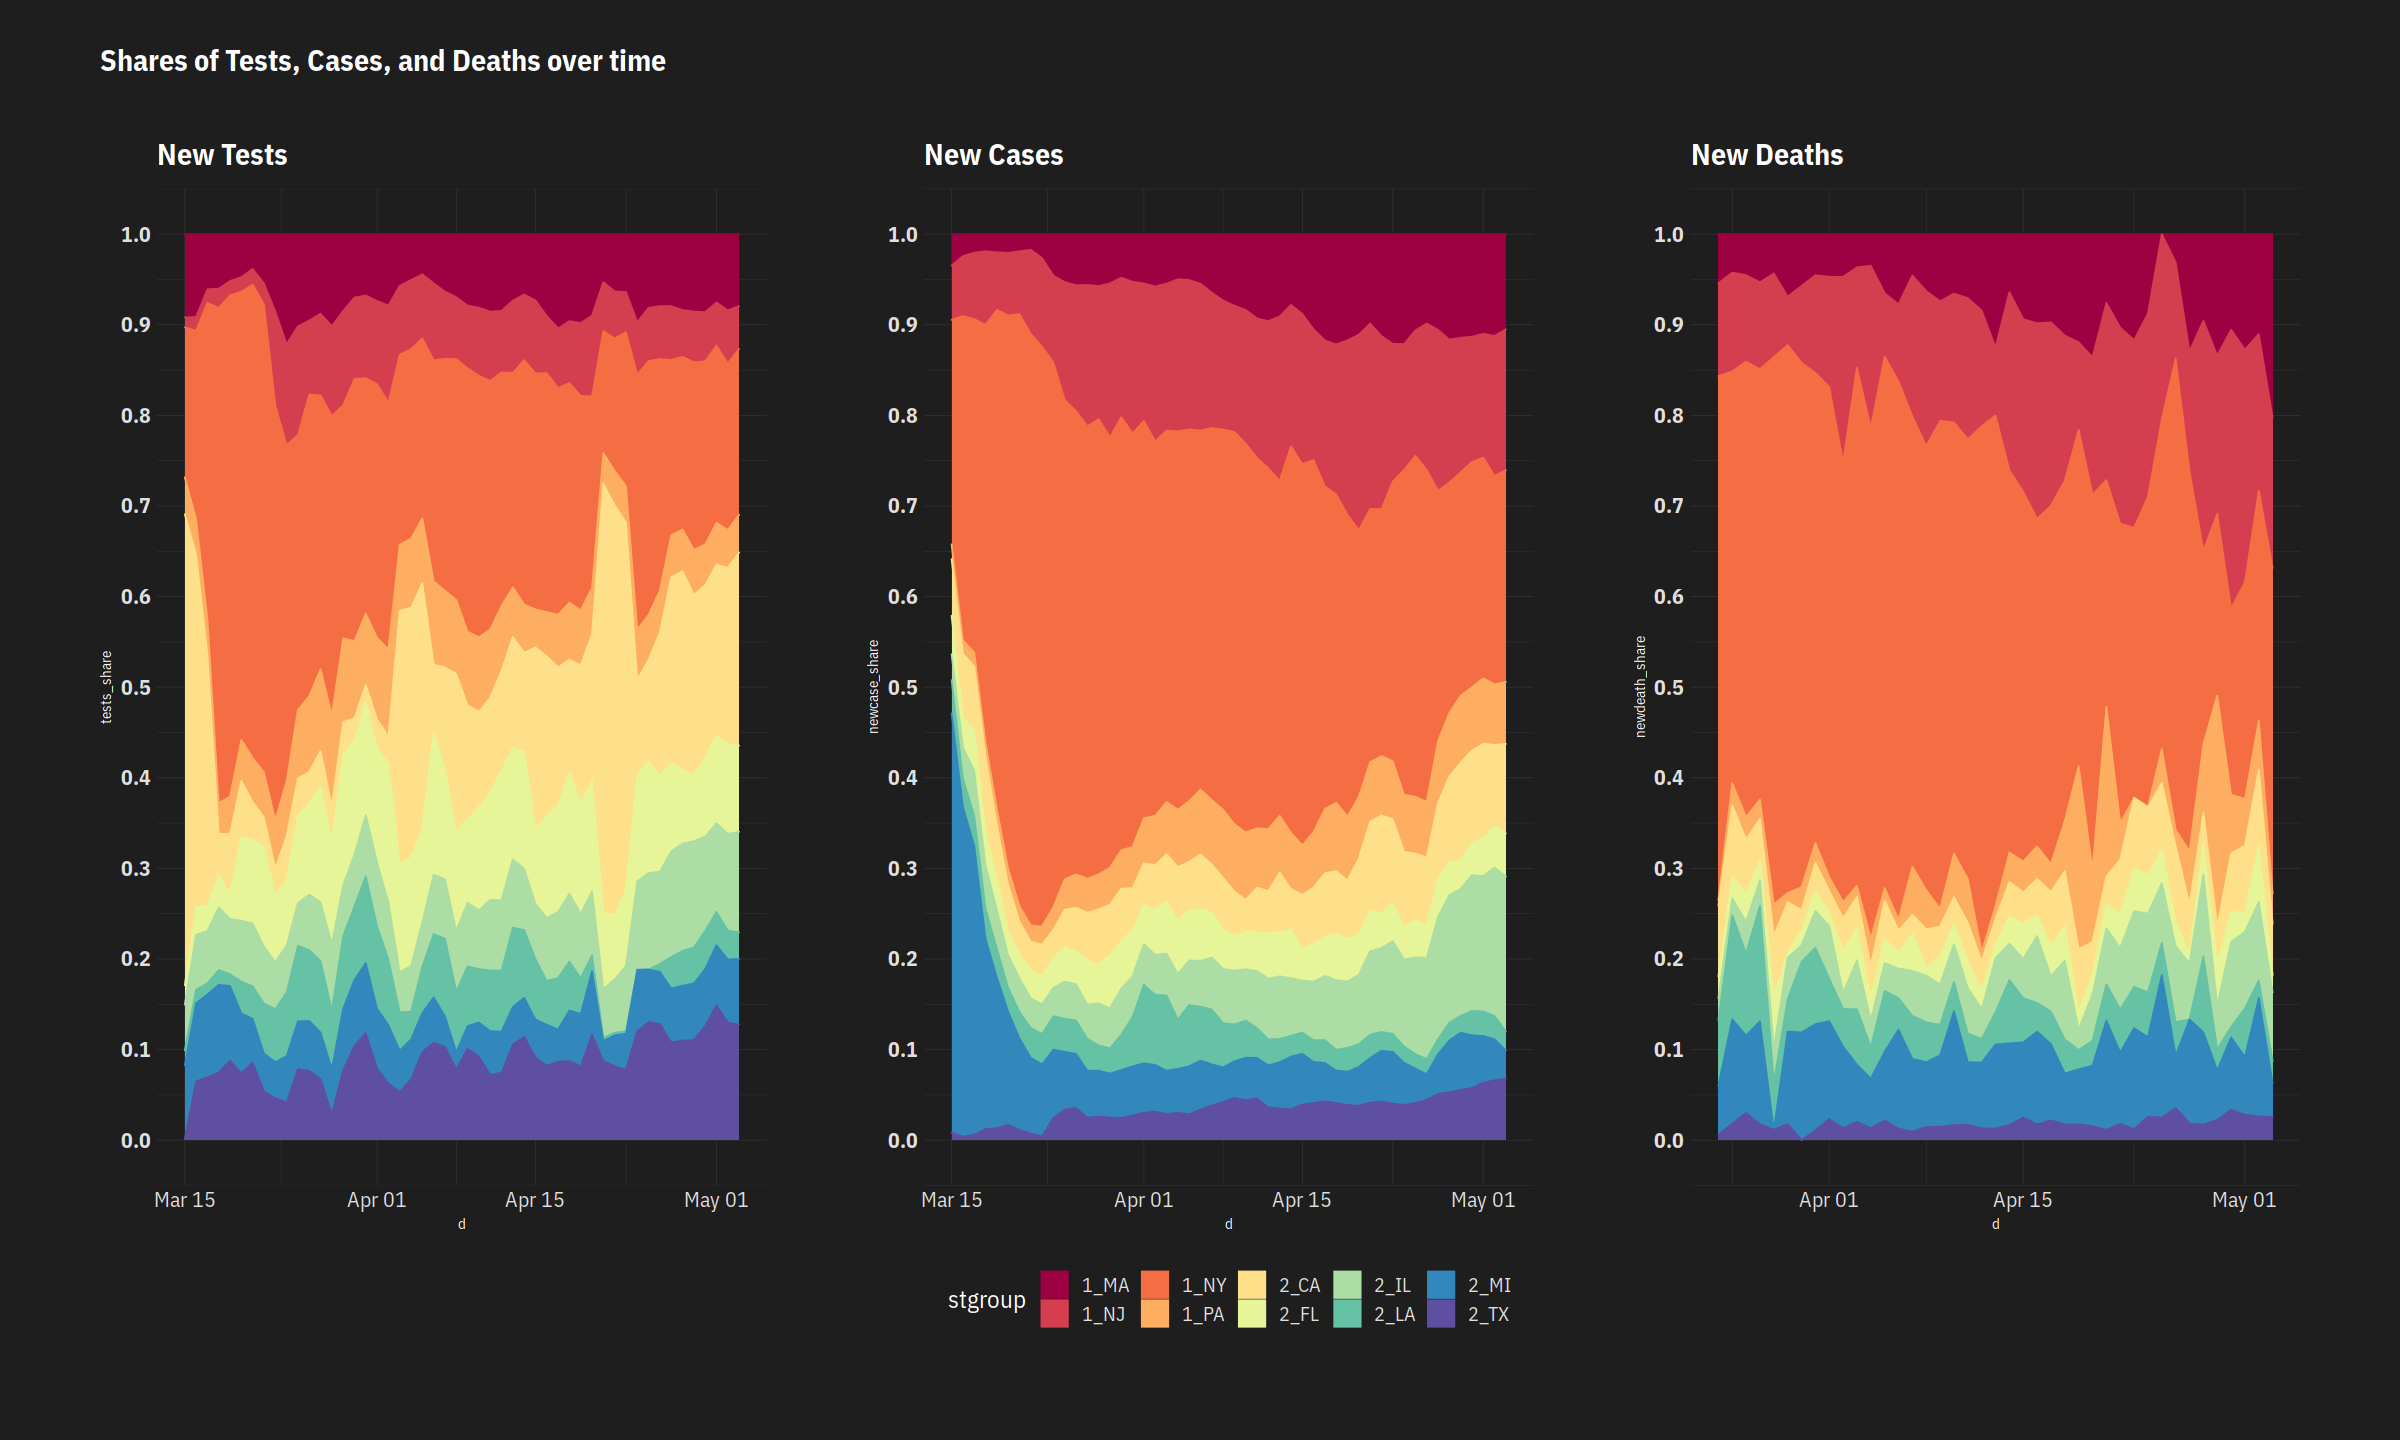

In [19]:
p1 = ggplot(t10states[d >= "2020-03-15"], aes(x = d, y = newcase_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(t10states[d >= "2020-03-24"], aes(x = d, y = newdeath_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    theme(legend.position = "None") + 
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")
p3 = ggplot(t10states[d >= "2020-03-15"], aes(x = d, y = tests_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    theme(legend.position = "None") + 
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Tests")
options(repr.plot.width = 20, repr.plot.height = 12)
(p3 | p1 | p2 ) + plot_annotation(title = "Shares of Tests, Cases, and Deaths over time")

## TPR

In [18]:
options(repr.plot.width = 15, repr.plot.height = 10)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



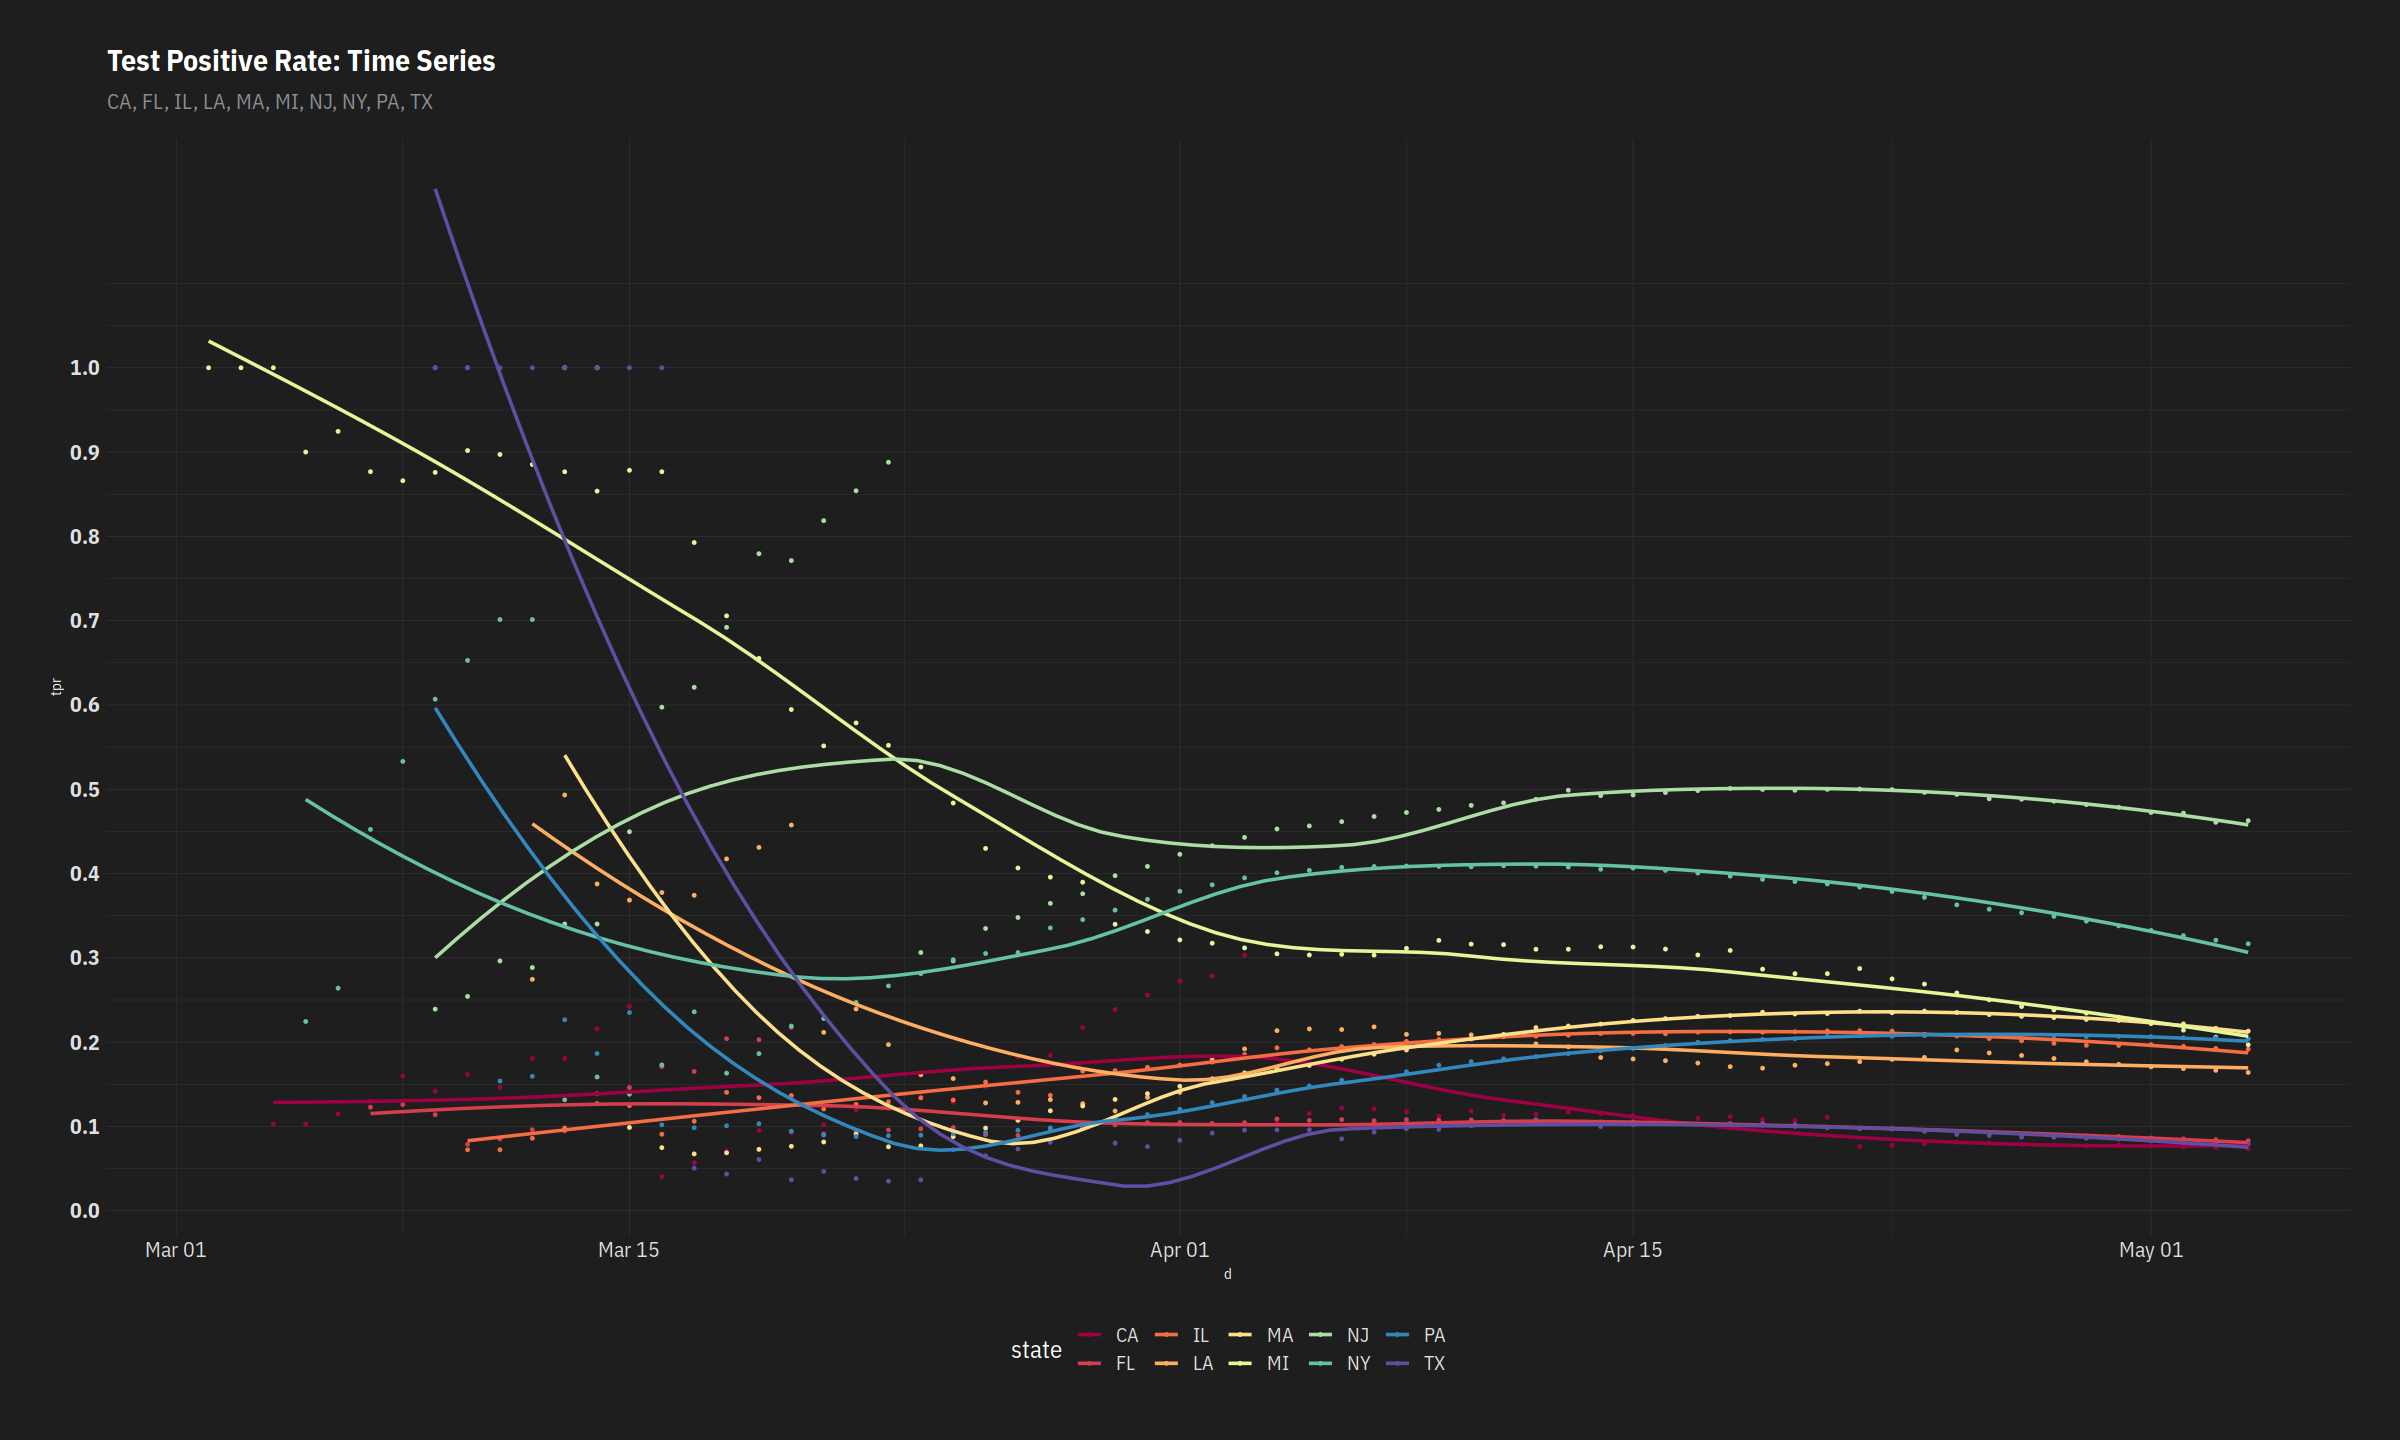

In [20]:
p1 = plot_ts(t10states, 'tpr', "Test Positive Rate: Time Series", T, F) +
    scale_y_continuous(breaks = seq(0, 1, .1))
# p2 = plot_ts(t10states, rm3_tpr, "Test Positive Rate (Rolling Mean): Time Series", T) +
#     scale_y_continuous(breaks = seq(0, 1, .1))
p1 

## New TPR

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 6 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


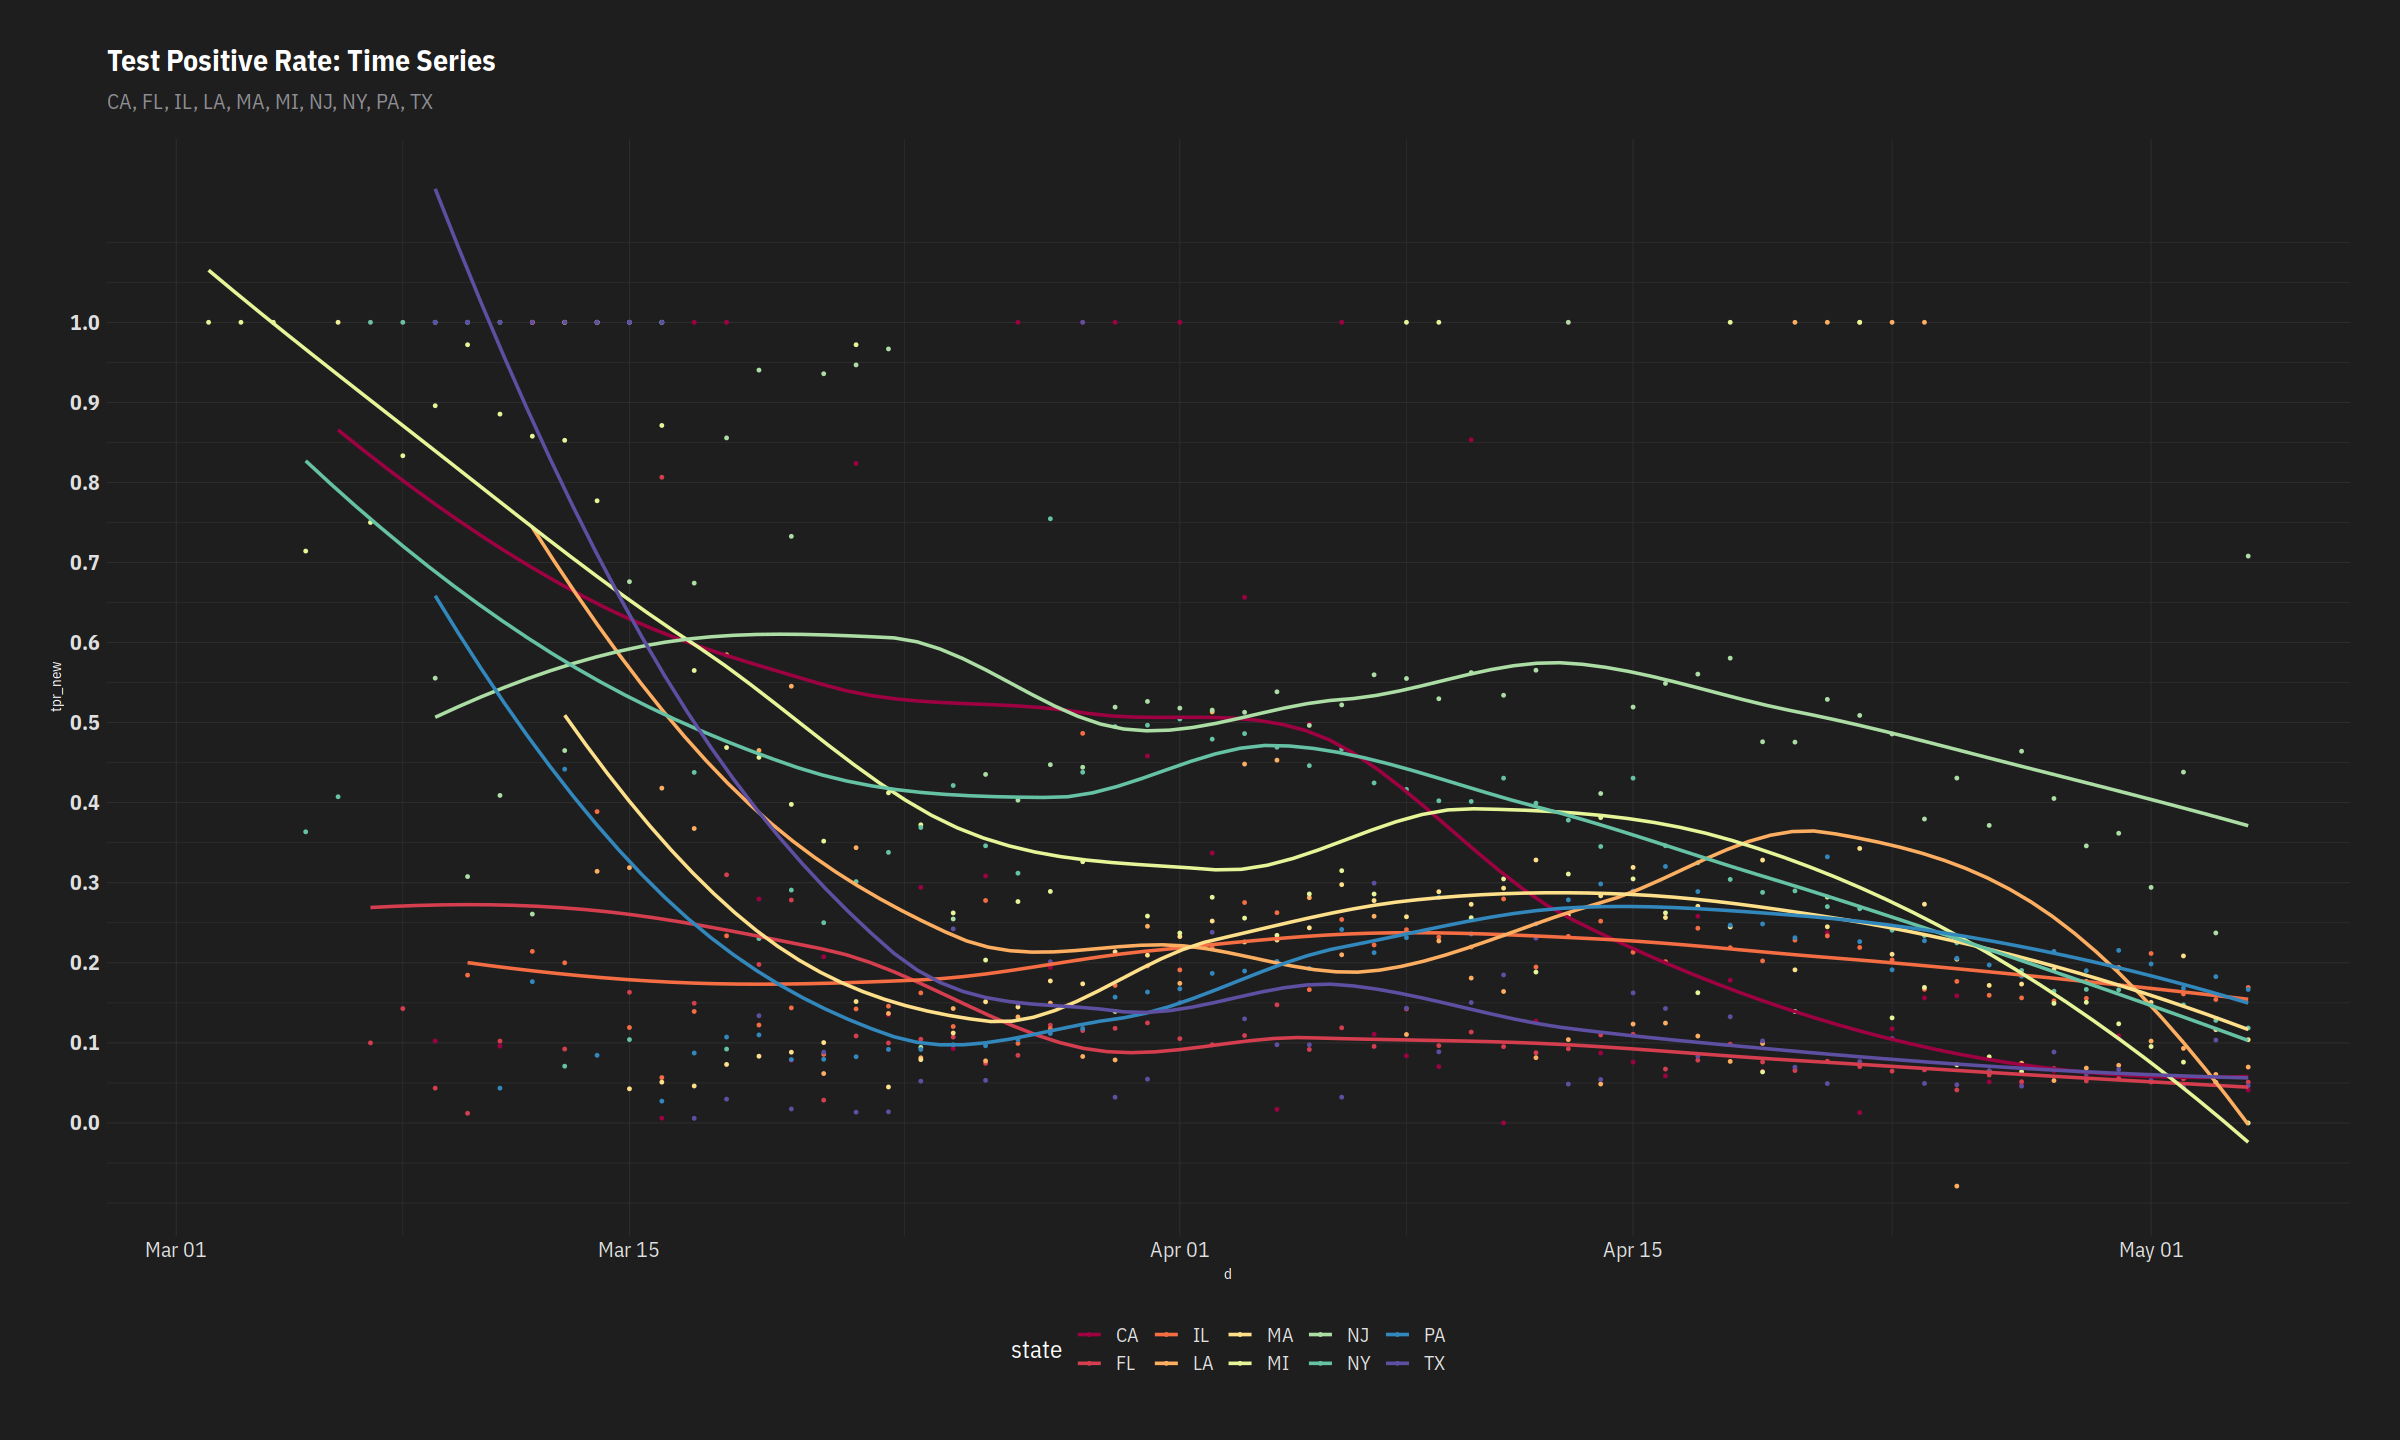

In [21]:
p1 = plot_ts(t10states, 'tpr_new', "Test Positive Rate: Time Series", T, F) +
    scale_y_continuous(breaks = seq(0, 1, .1))

p1 

# Day-of-week effects 

In [23]:
dt = t10states[d >= '2020-03-15']
dt[, wknd := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
dt[, t := date - 20200315] # time trend 
dt$day2 = as.factor(dt$day) 

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


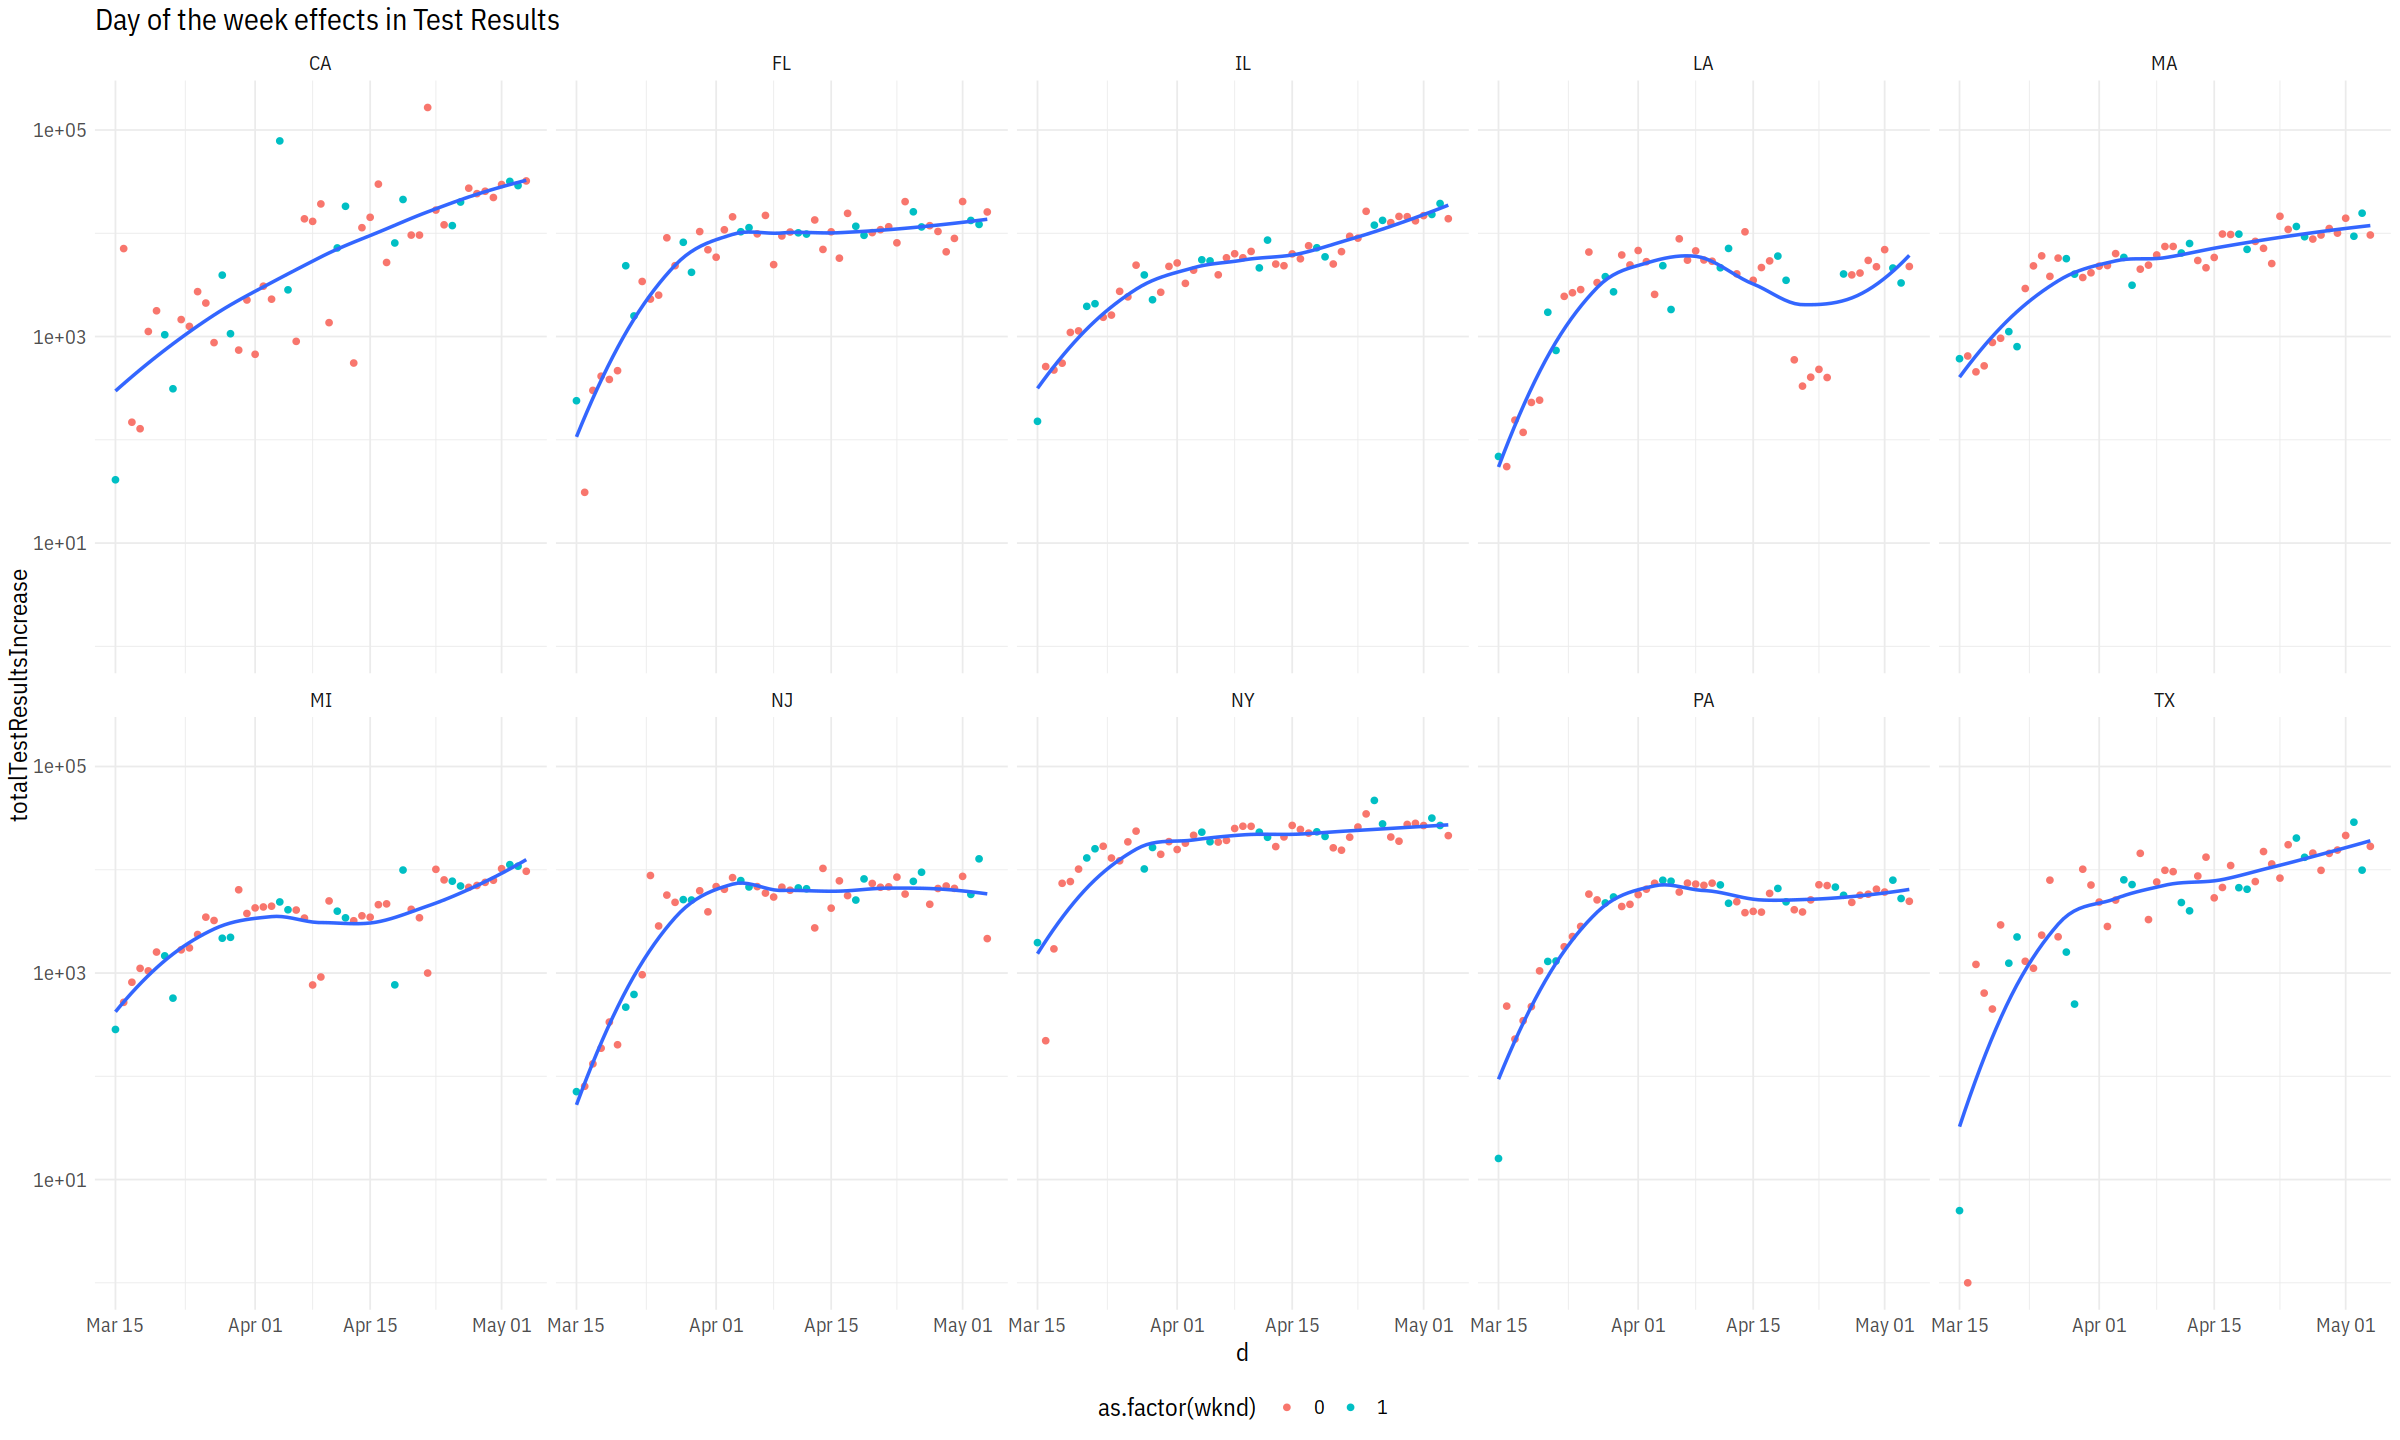

In [24]:
(p = ggplot(dt, aes(d, y = totalTestResultsIncrease)) +
    geom_point(aes(colour = as.factor(wknd))) + 
    geom_smooth(se = F) +
    labs(title = "Day of the week effects in Test Results") +
    facet_wrap(~ state, 2) +
    lal_plot_theme() +
    scale_y_log10()
)

In [27]:
day_of_week_plot = function(df){
    d = df %>% filter(term != "(Intercept)") %>% 
        mutate(day = str_replace(term, "relevel\\(day2, 2\\)", "")) %>% 
        mutate(ord_day = case_when(
            day == "Monday" ~ 1,  day == "Tuesday" ~ 2,  day == "Wednesday" ~ 3,  day == "Thursday" ~ 4, 
            day == "Friday" ~ 5,  day == "Saturday" ~ 6,  day == "Sunday" ~ 7
        ), wknd = as.factor(ifelse(day %in% c("Saturday", "Sunday"), 1, 0))) %>% 
        mutate(ub = estimate + 1.96 * `std.error`, 
               lb = estimate - 1.96 * `std.error`)
    stname = unique(df$state)
    p = ggplot(d, aes(x = ord_day,y = estimate, colour = wknd)) +
        geom_point() + 
        theme(legend.position = "None") +
        geom_pointrange(aes(ymin = lb, ymax = ub)) + 
        labs(title = stname)
}

Warning message in log(totalTestResultsIncrease + 1):
“NaNs produced”


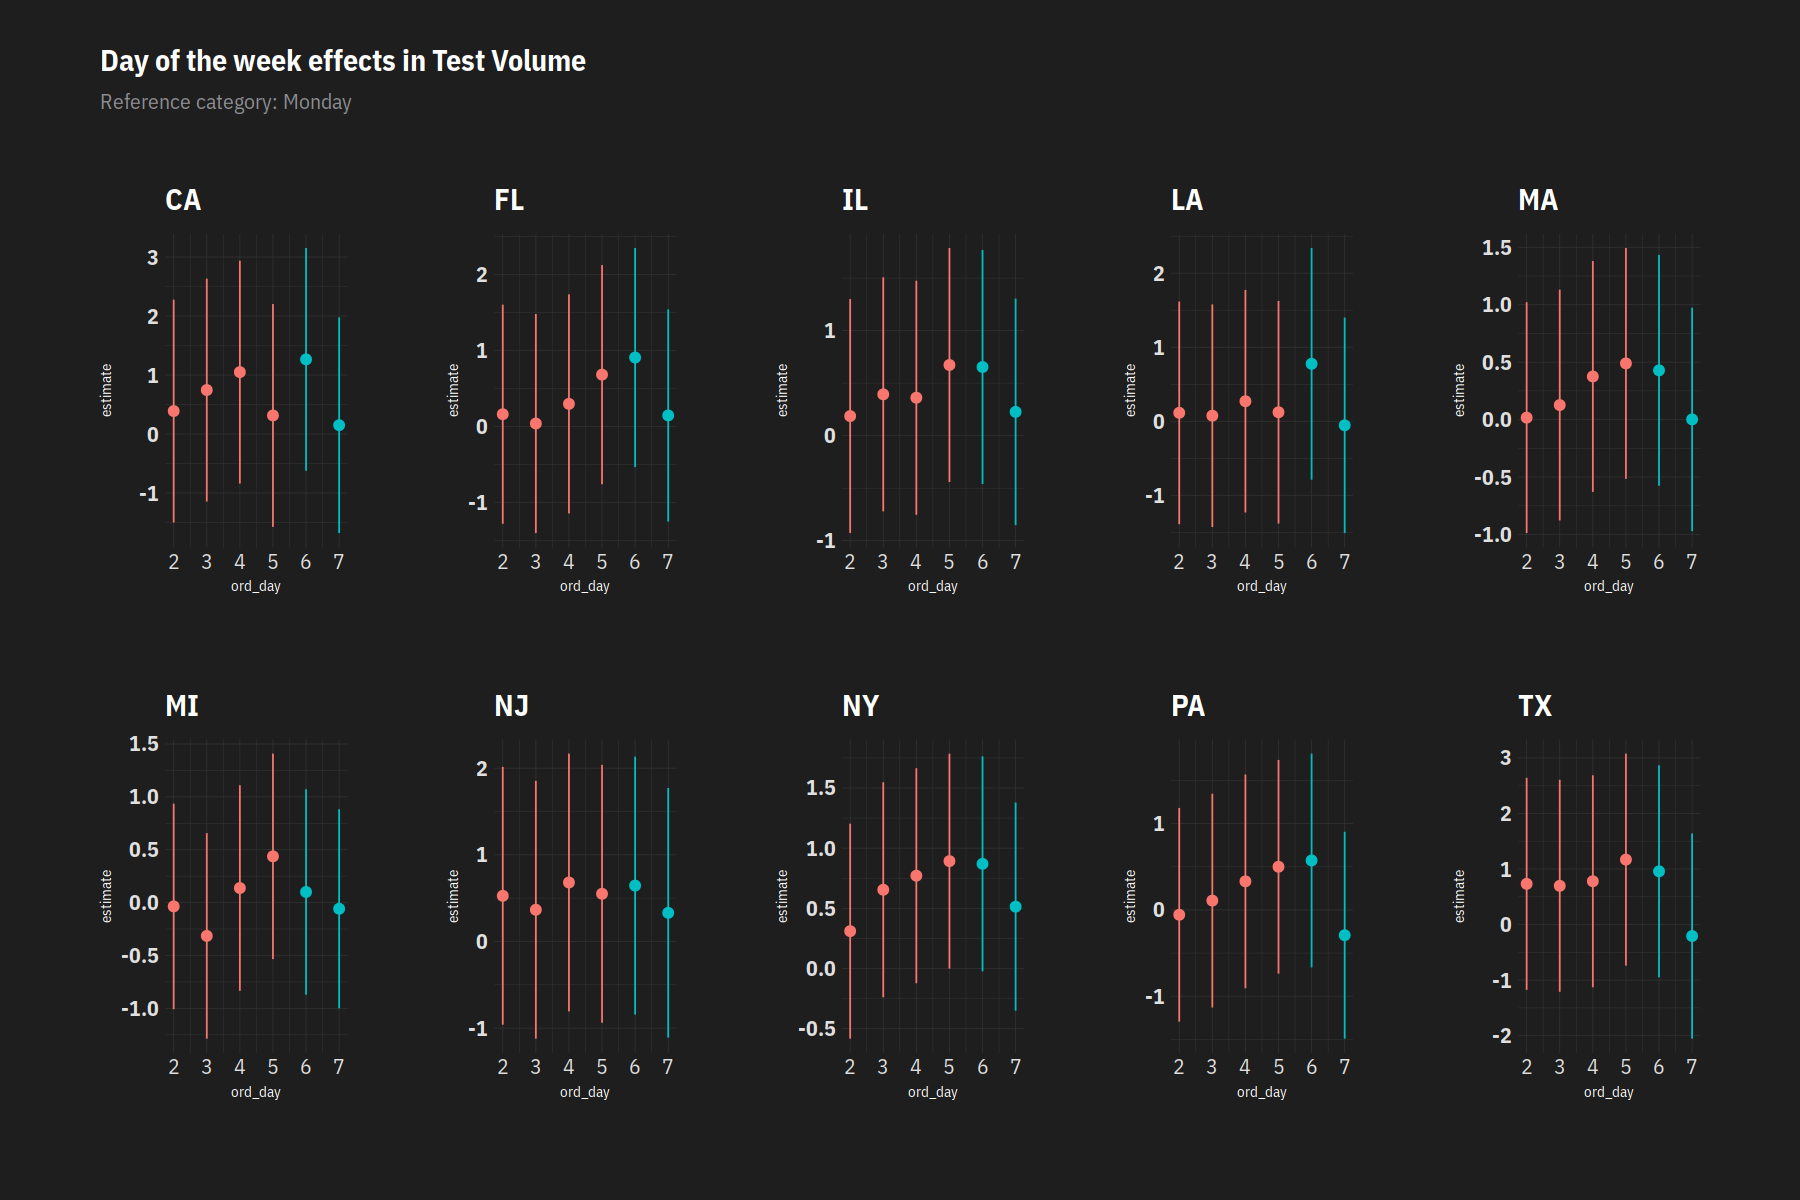

In [28]:
test_increase_regs = dt %>% group_by(state) %>% group_map( ~ lm(log(totalTestResultsIncrease+1) ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(test_increase_regs , day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in Test Volume',
    subtitle = 'Reference category: Monday',
)

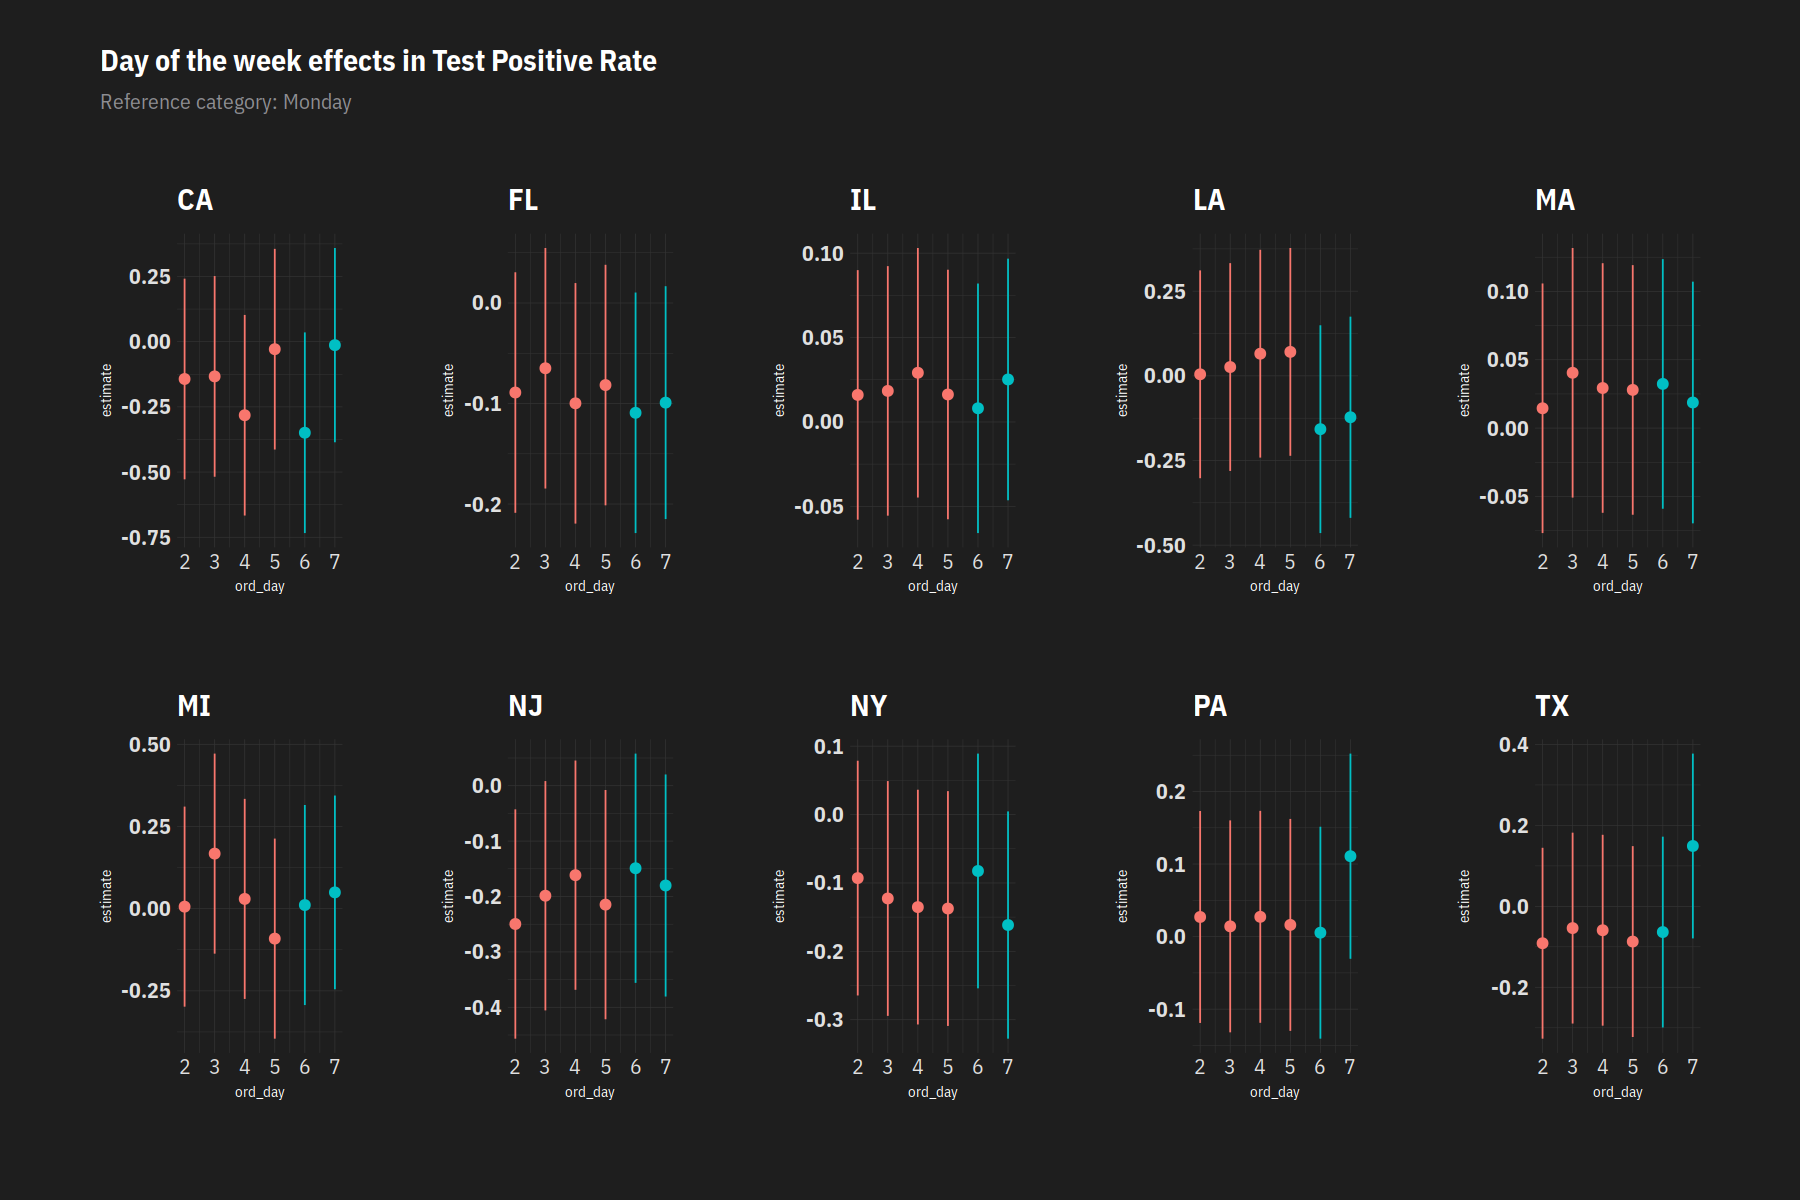

In [29]:
positive_rate = dt %>% group_by(state) %>% group_map( ~ lm(tpr_new ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(positive_rate, day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in Test Positive Rate',
    subtitle = 'Reference category: Monday',
)

Warning message in log(deathIncrease + 1):
“NaNs produced”


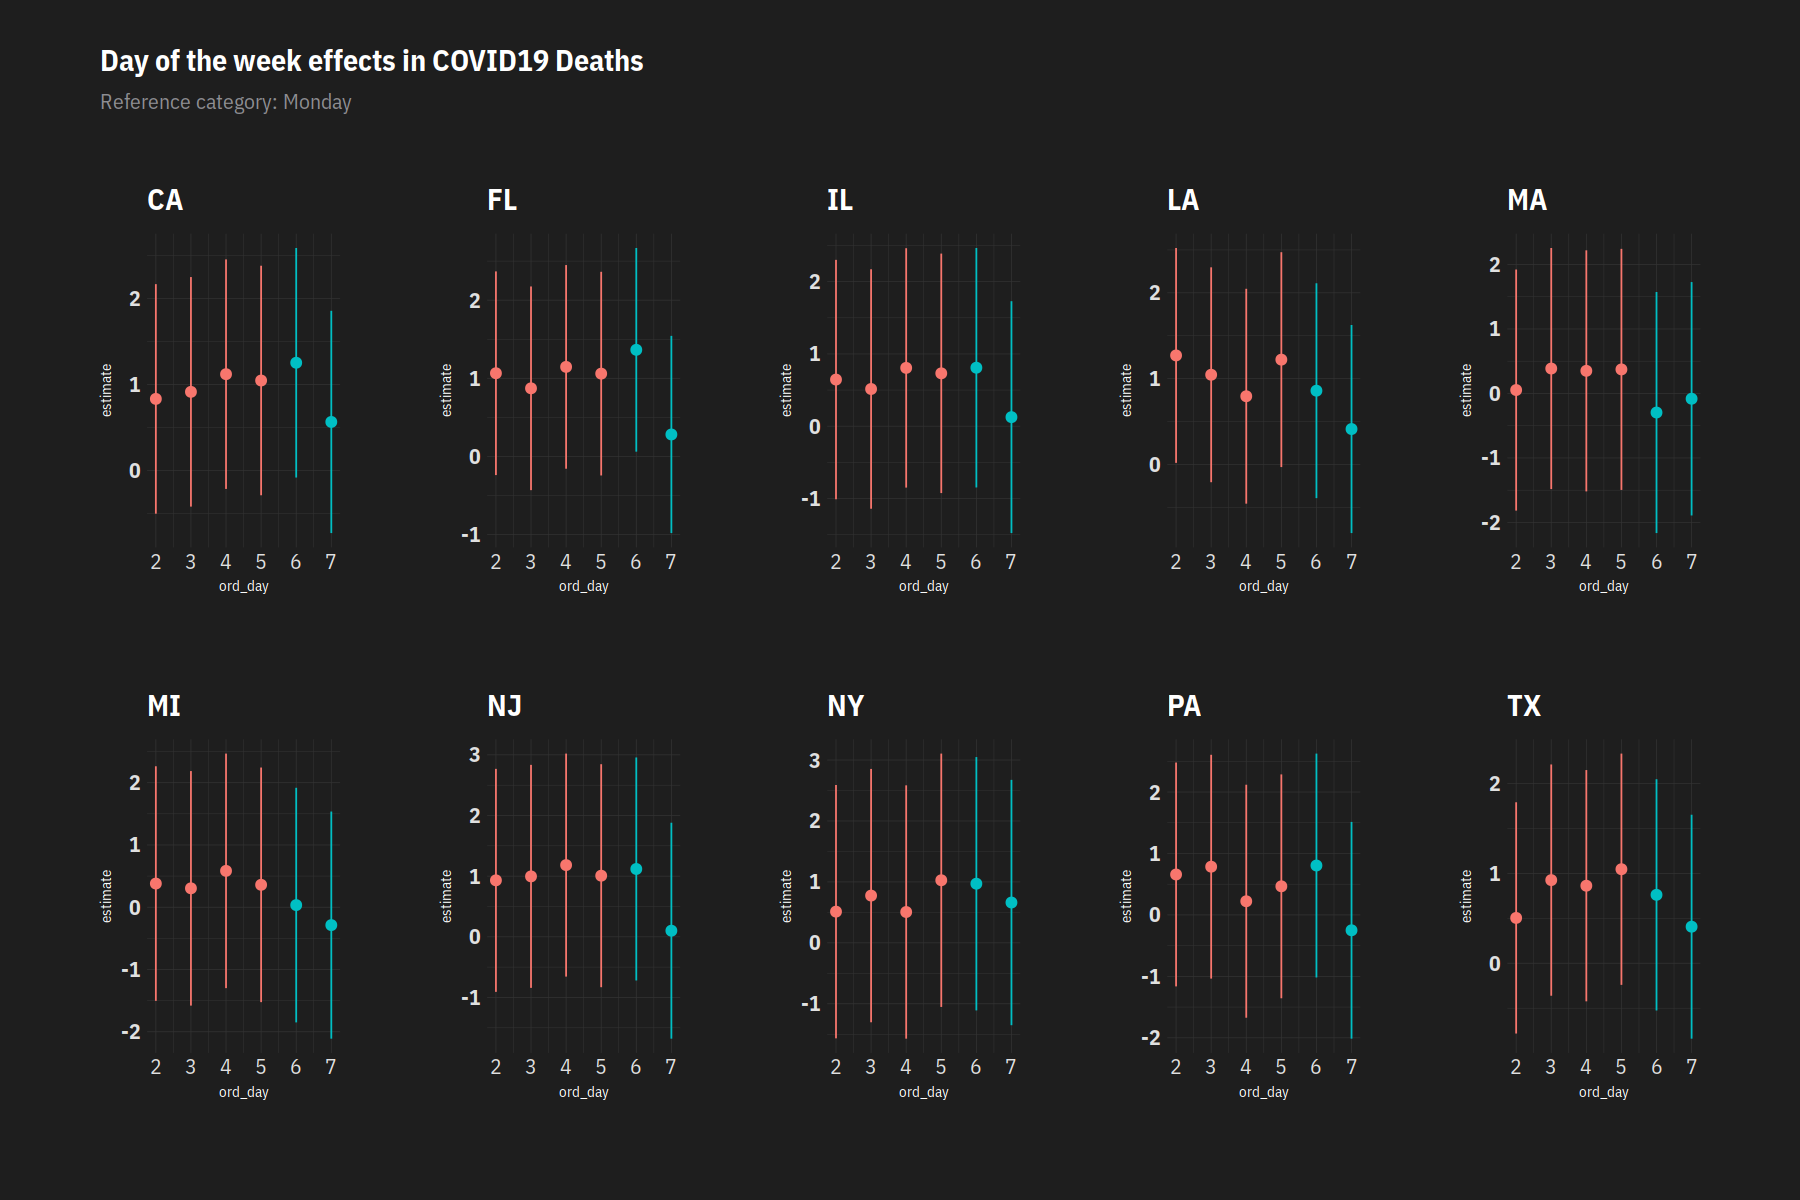

In [30]:
dths = dt %>% group_by(state) %>% group_map( ~ lm(log(deathIncrease+1) ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(dths, day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in COVID19 Deaths',
    subtitle = 'Reference category: Monday',
)